## Goal: make plots of spectra of detided bottom pressure records

Make some plots of the de-tided bottom pressure records from the pre-SWOT experiment off of California.  Specifically, we want:
1. Spectra of detided bottom pressure records
2. The spectrum of the difference of the detided records
    

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from matplotlib.colors import LogNorm
from matplotlib import cm
import matplotlib
from scipy import stats
from scipy import signal
import xarray as xr
import Tom_tools_v1
import datetime

In [2]:
# %matplotlib qt 
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 400
plt.close('all')

__figdir__ = './figs/' + 'Tom_'
savefig_args = {'bbox_inches':'tight', 'pad_inches':0.2}

In [3]:
path = 'data/'
file1 = 'PMEL.BP.analyzed.nc'
file2 = 'SIO.BP.analyzed.nc'
ds1 = xr.open_dataset(path+file1)
ds2 = xr.open_dataset(path+file2)
ds1


<xarray.Dataset>
Dimensions:            (time: 787514)
Coordinates:
  * time               (time) datetime64[ns] 2019-09-04T23:41:00 ... 2020-01-...
Data variables:
    bp_detided         (time) float64 ...
    bp_tide            (time) float64 ...
    SEAFLOOR_PRESSURE  (time) float64 ...

In [4]:
# determine sampling interval
dt1 = ds1.time[1]-ds1.time[0]
dt_pmel = float(dt1 / np.timedelta64(1, 'D'))
dt2 = ds2.time[1]-ds2.time[0]
dt_sio = float(dt2 / np.timedelta64(1, 'D'))
dt_sio

0.0006944444444444445

In [5]:
ds1.bp_tide.unit

'Pascal'

In [6]:
ds1.bp_detided/1020/9.8

<xarray.DataArray 'bp_detided' (time: 787514)>
array([4560.3875117 , 4560.38710761, 4560.38773174, ..., 4560.08710486,
       4560.08745497, 4560.08677686])
Coordinates:
  * time     (time) datetime64[ns] 2019-09-04T23:41:00 ... 2020-01-19T16:59:15

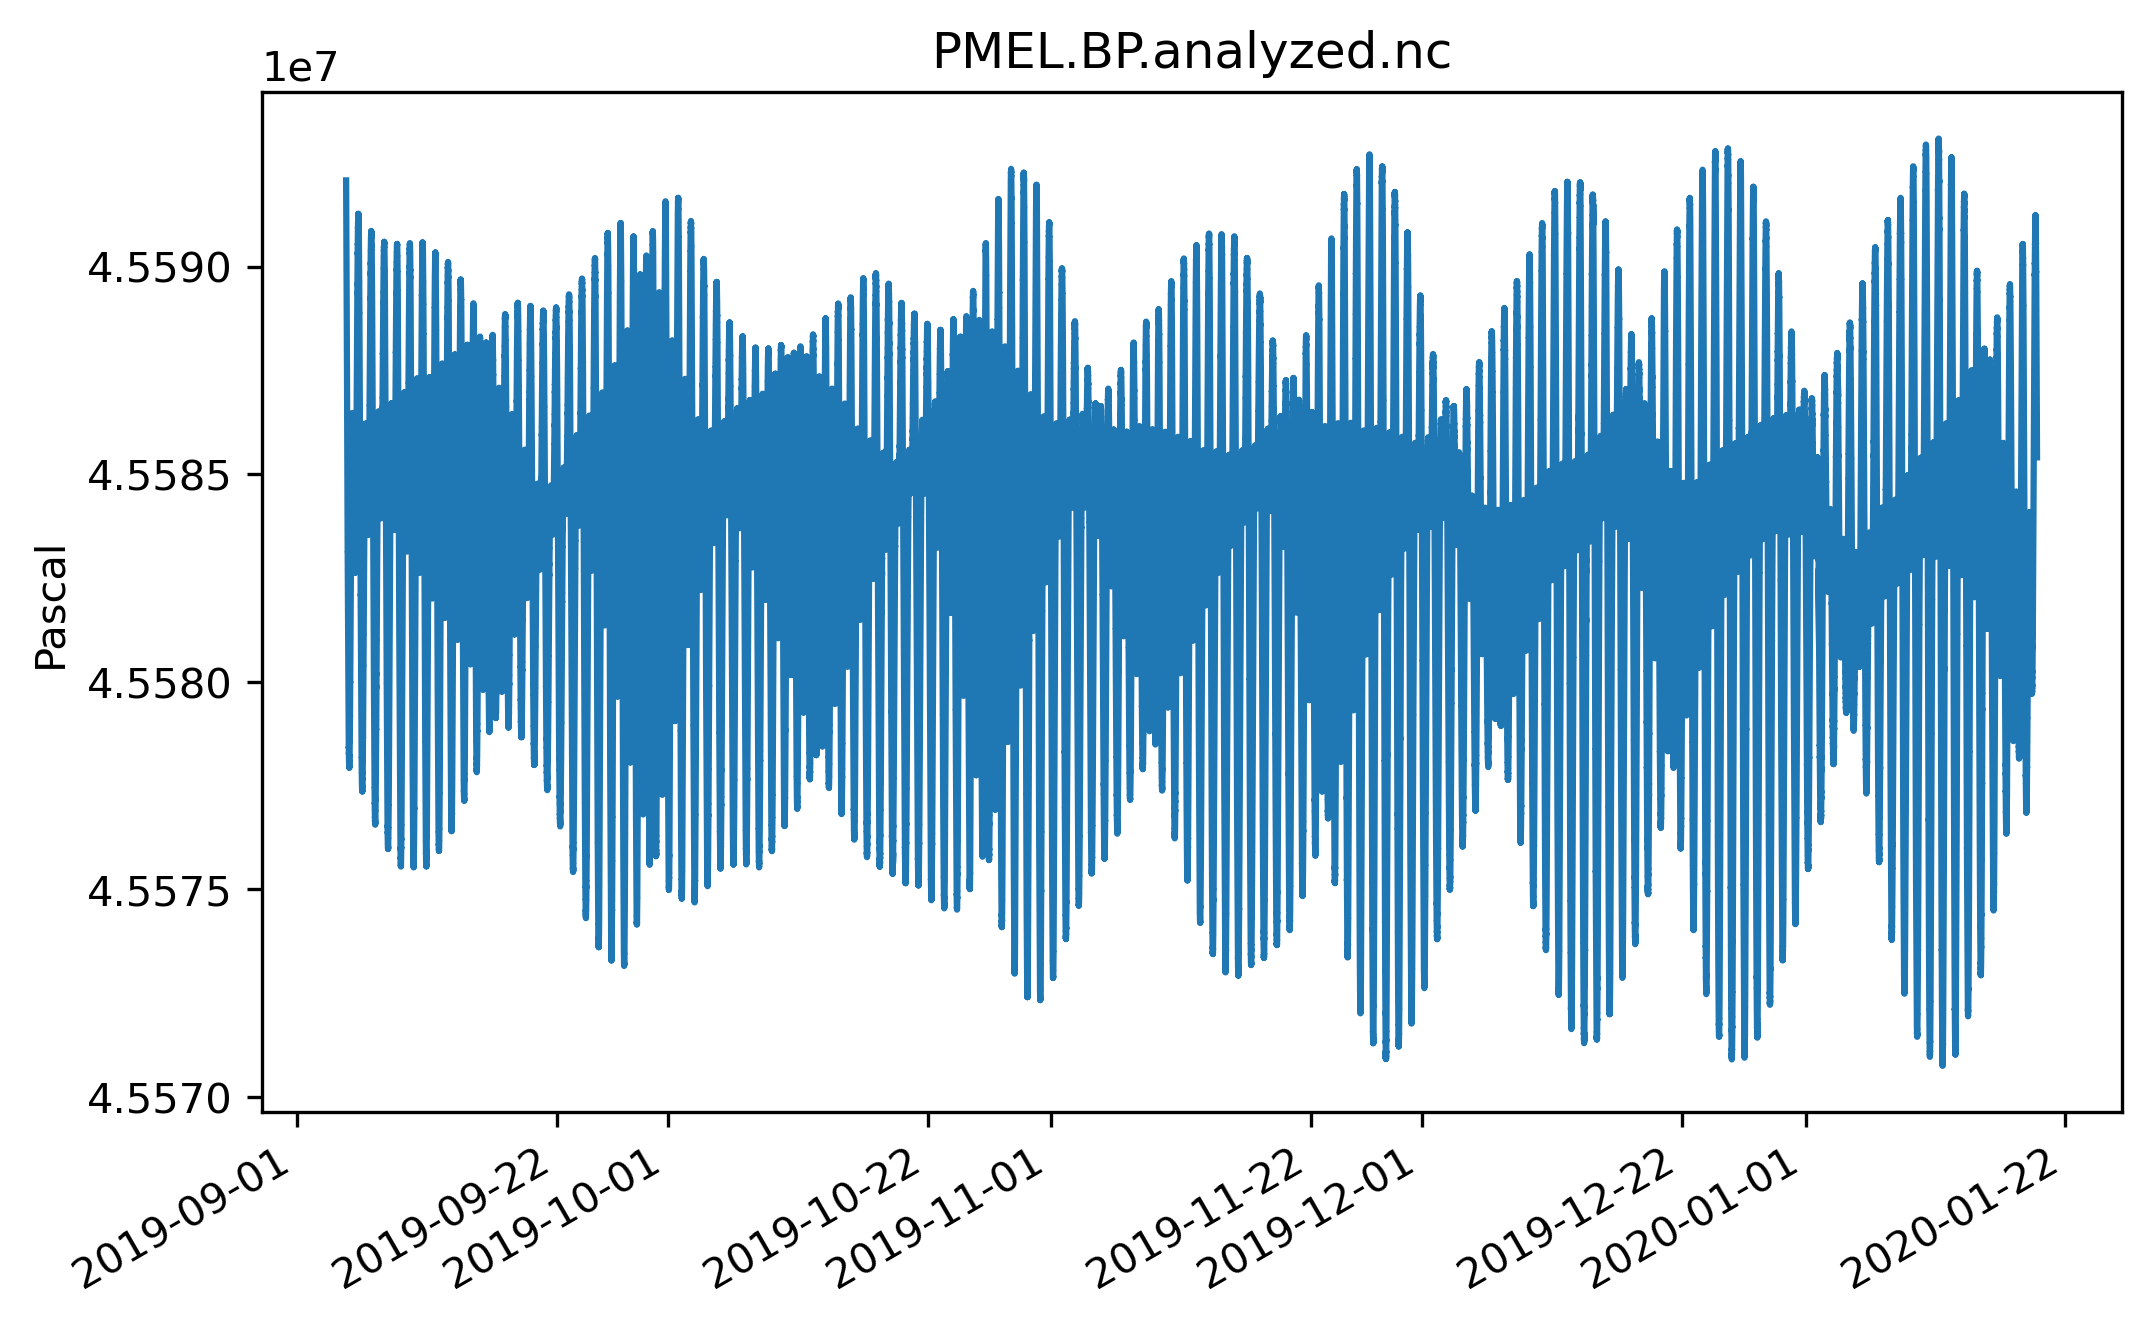

In [7]:
fig, ax = plt.subplots(1, 1)
ax.plot(ds1.time,ds1.SEAFLOOR_PRESSURE)
ax.set(ylabel=ds1.bp_tide.unit)
ax.set_title(file1)

fig.autofmt_xdate()

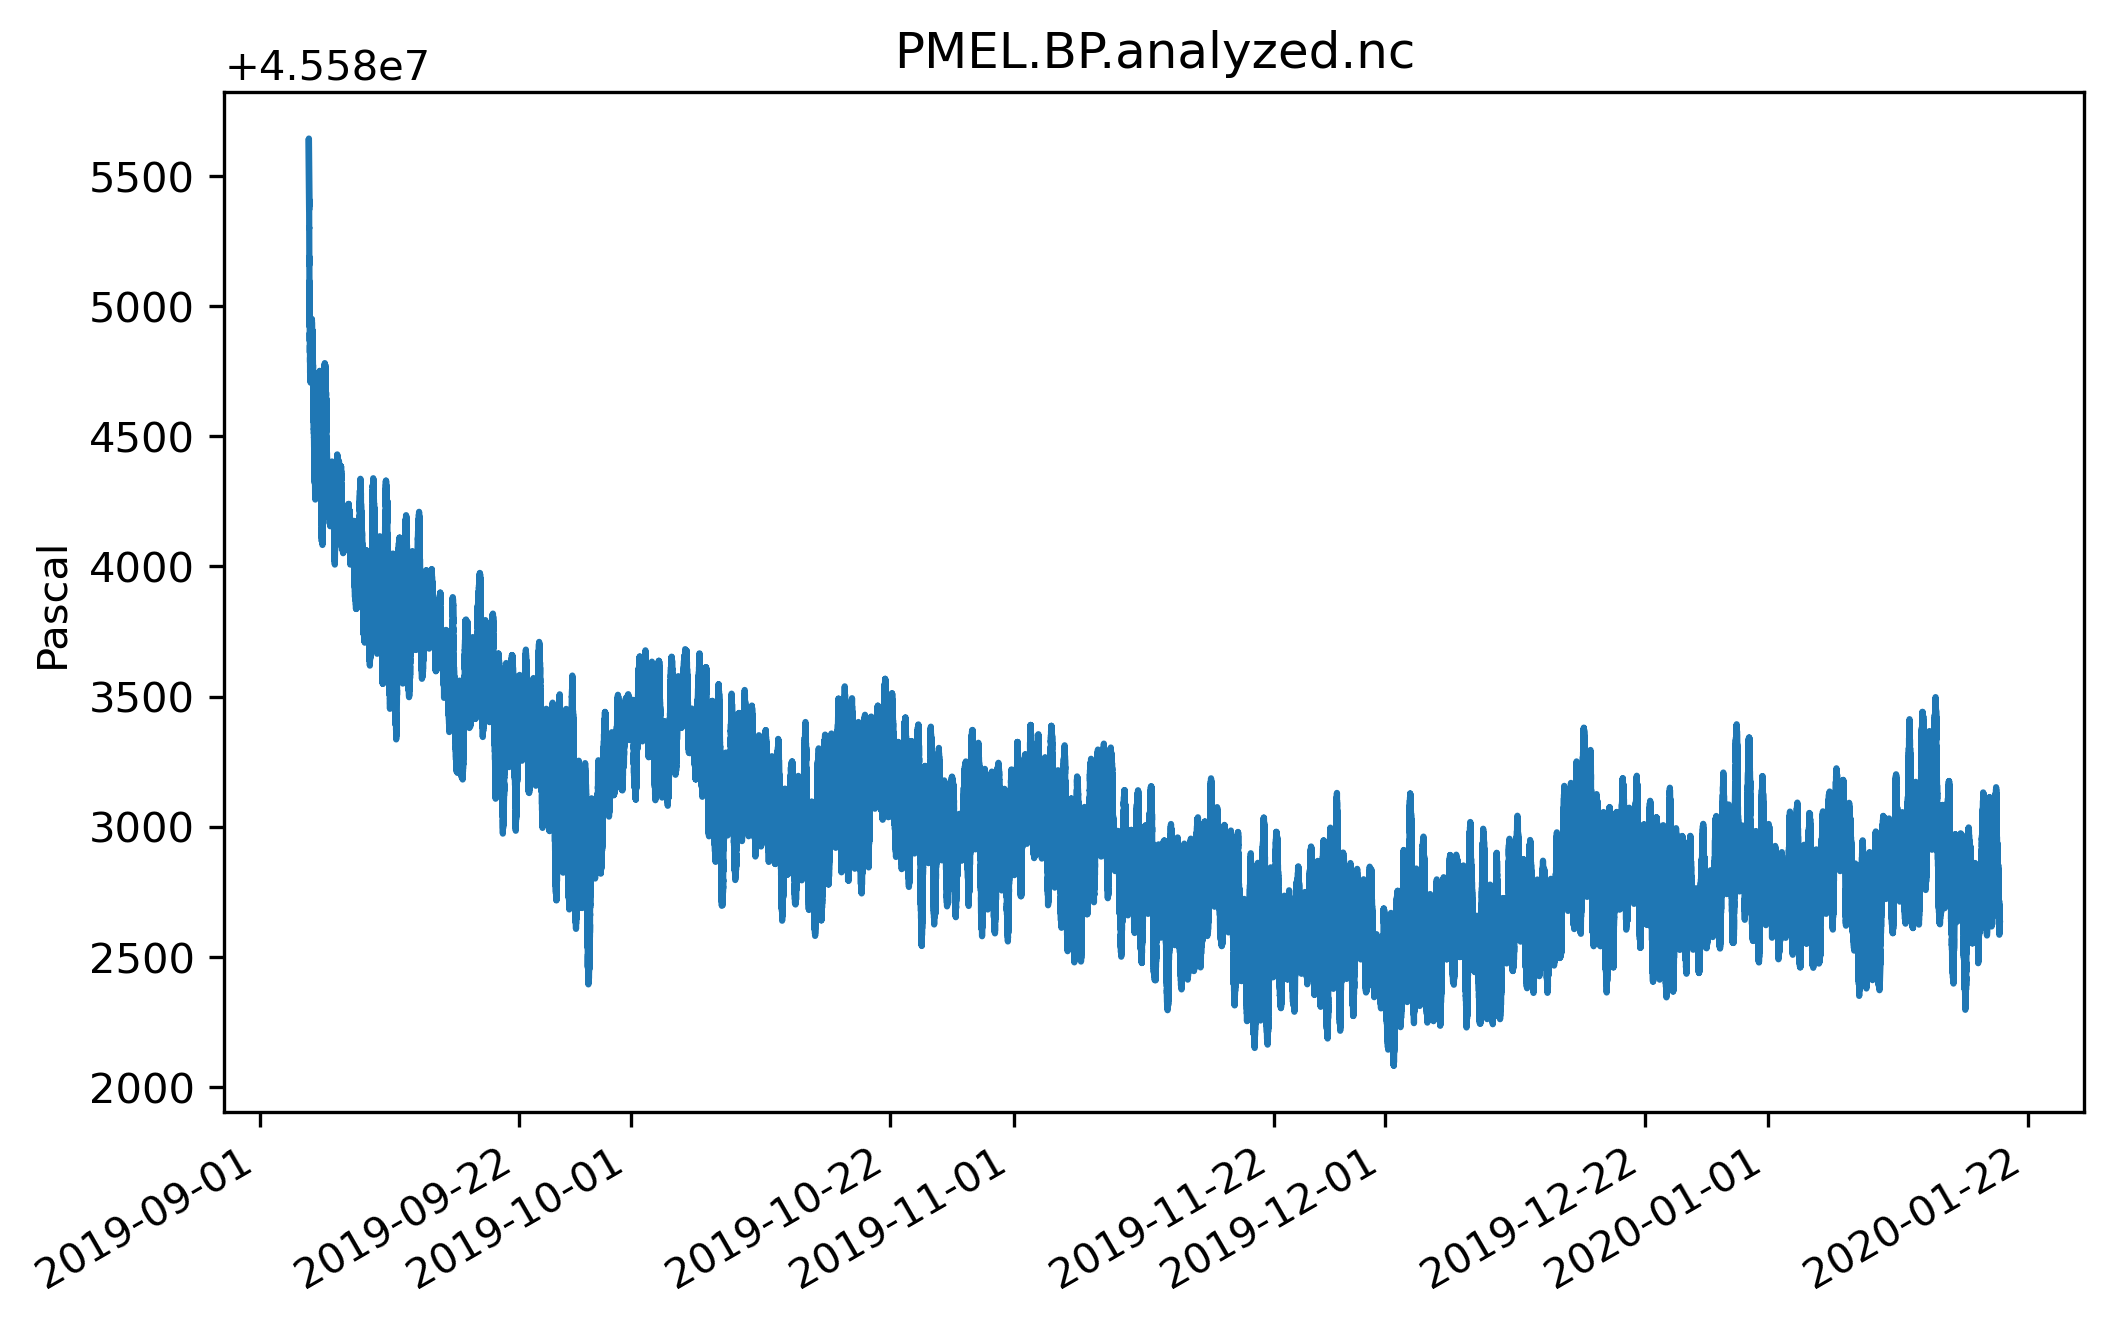

In [8]:
fig, ax = plt.subplots(1, 1)
ax.plot(ds1.time,ds1.bp_detided)
ax.set(ylabel=ds1.bp_tide.unit)
ax.set_title(file1)

fig.autofmt_xdate()

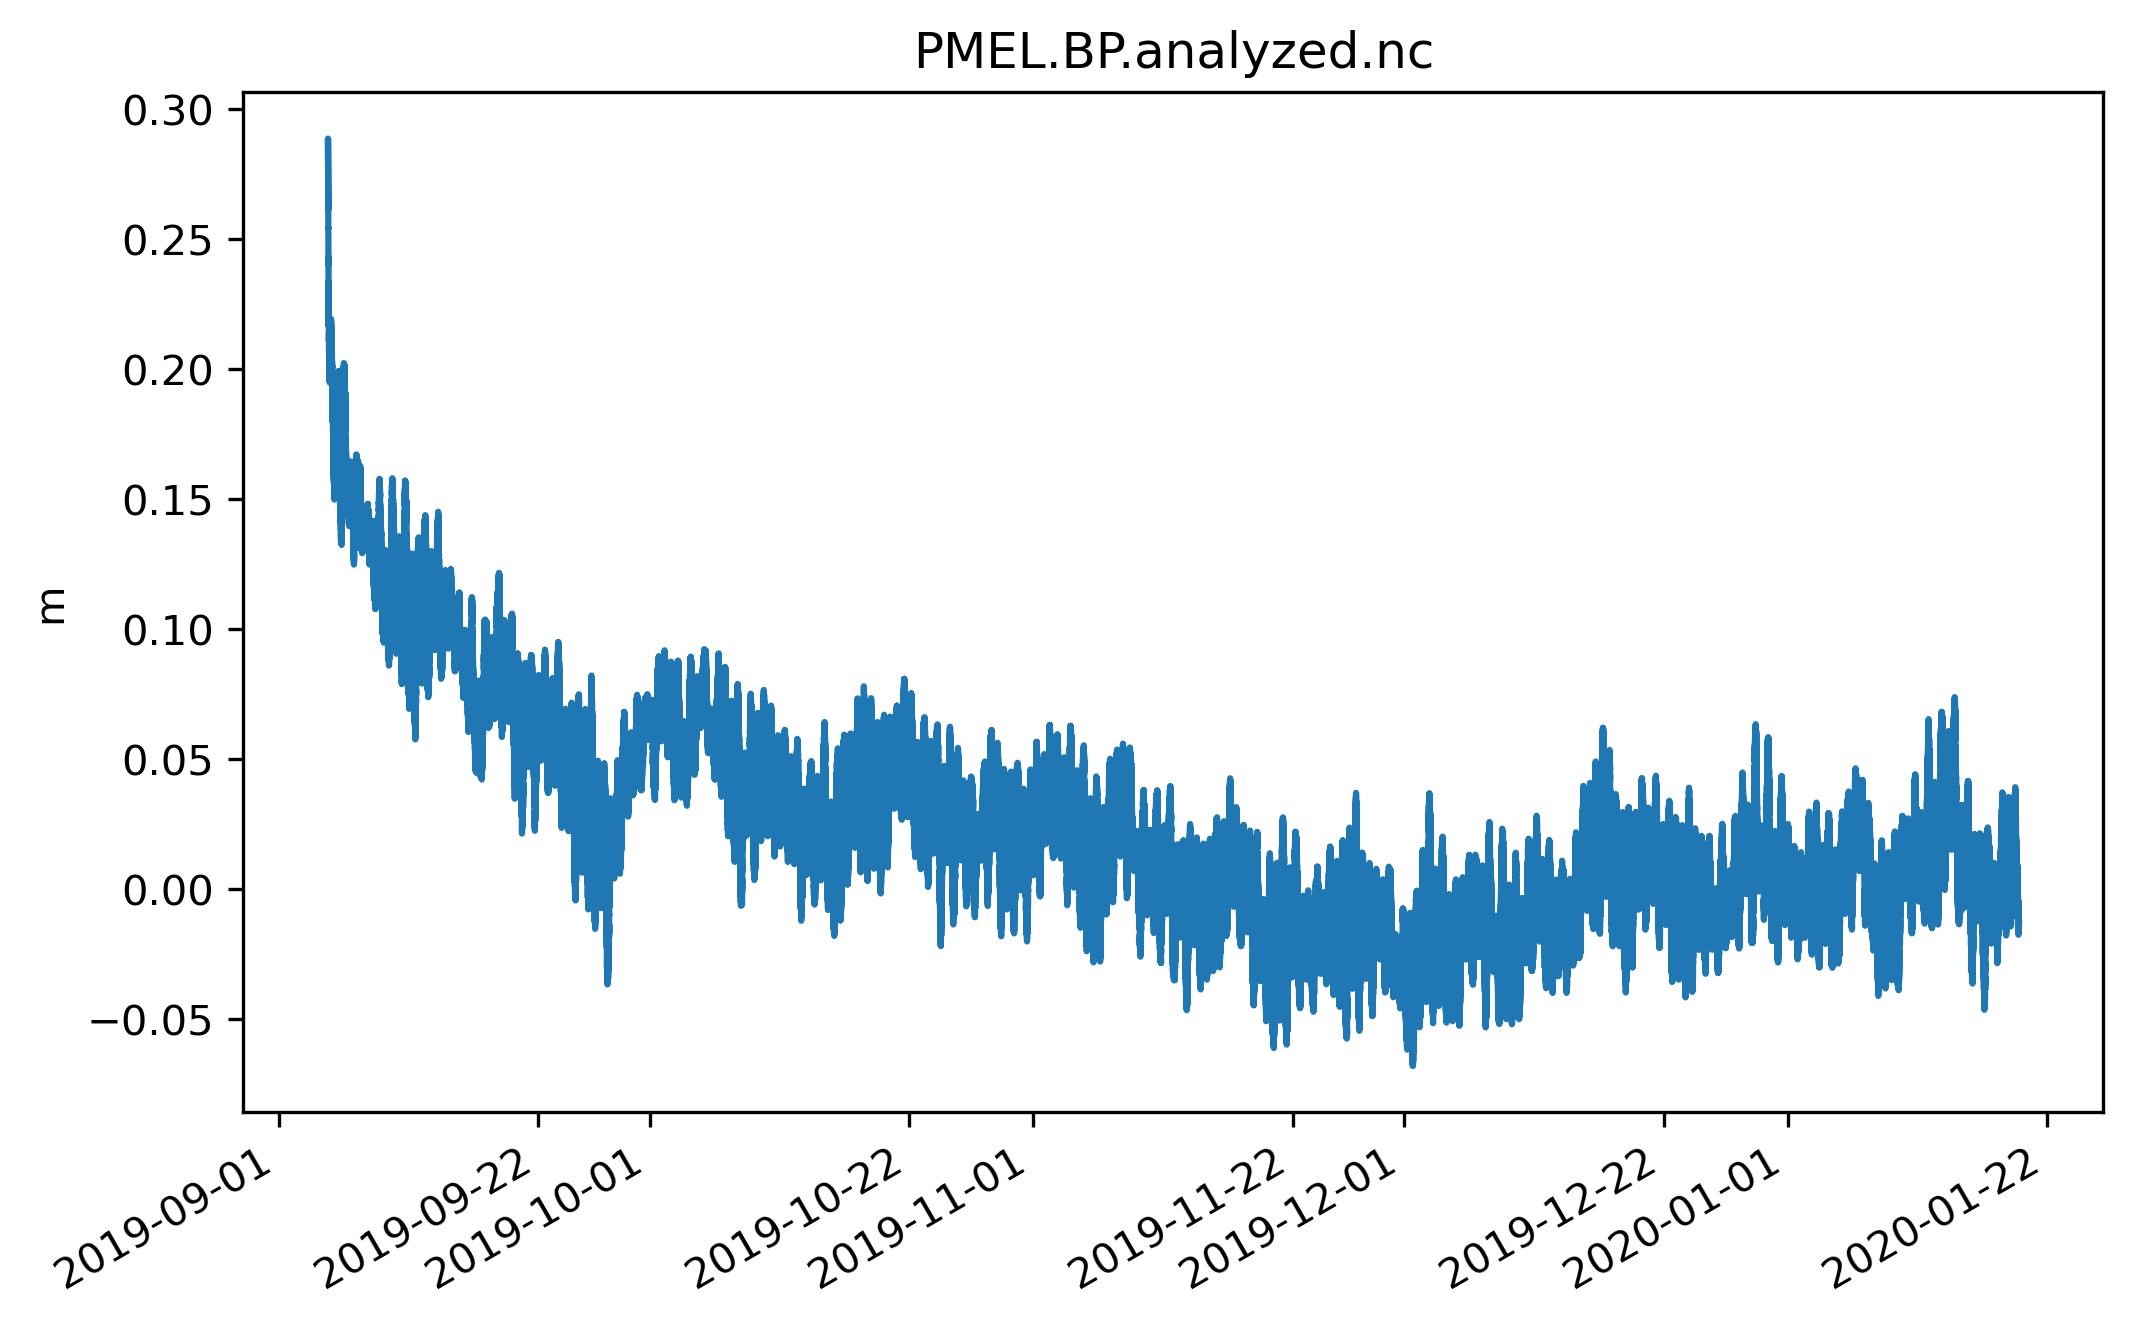

In [9]:
fig, ax = plt.subplots(1, 1)
ax.plot(ds1.time,ds1.bp_detided/1020/9.8-4560.1)
ax.set(ylabel='m')
ax.set_title(file1)

fig.autofmt_xdate()
plt.savefig(__figdir__+'PMEL_detided.pdf',**savefig_args)

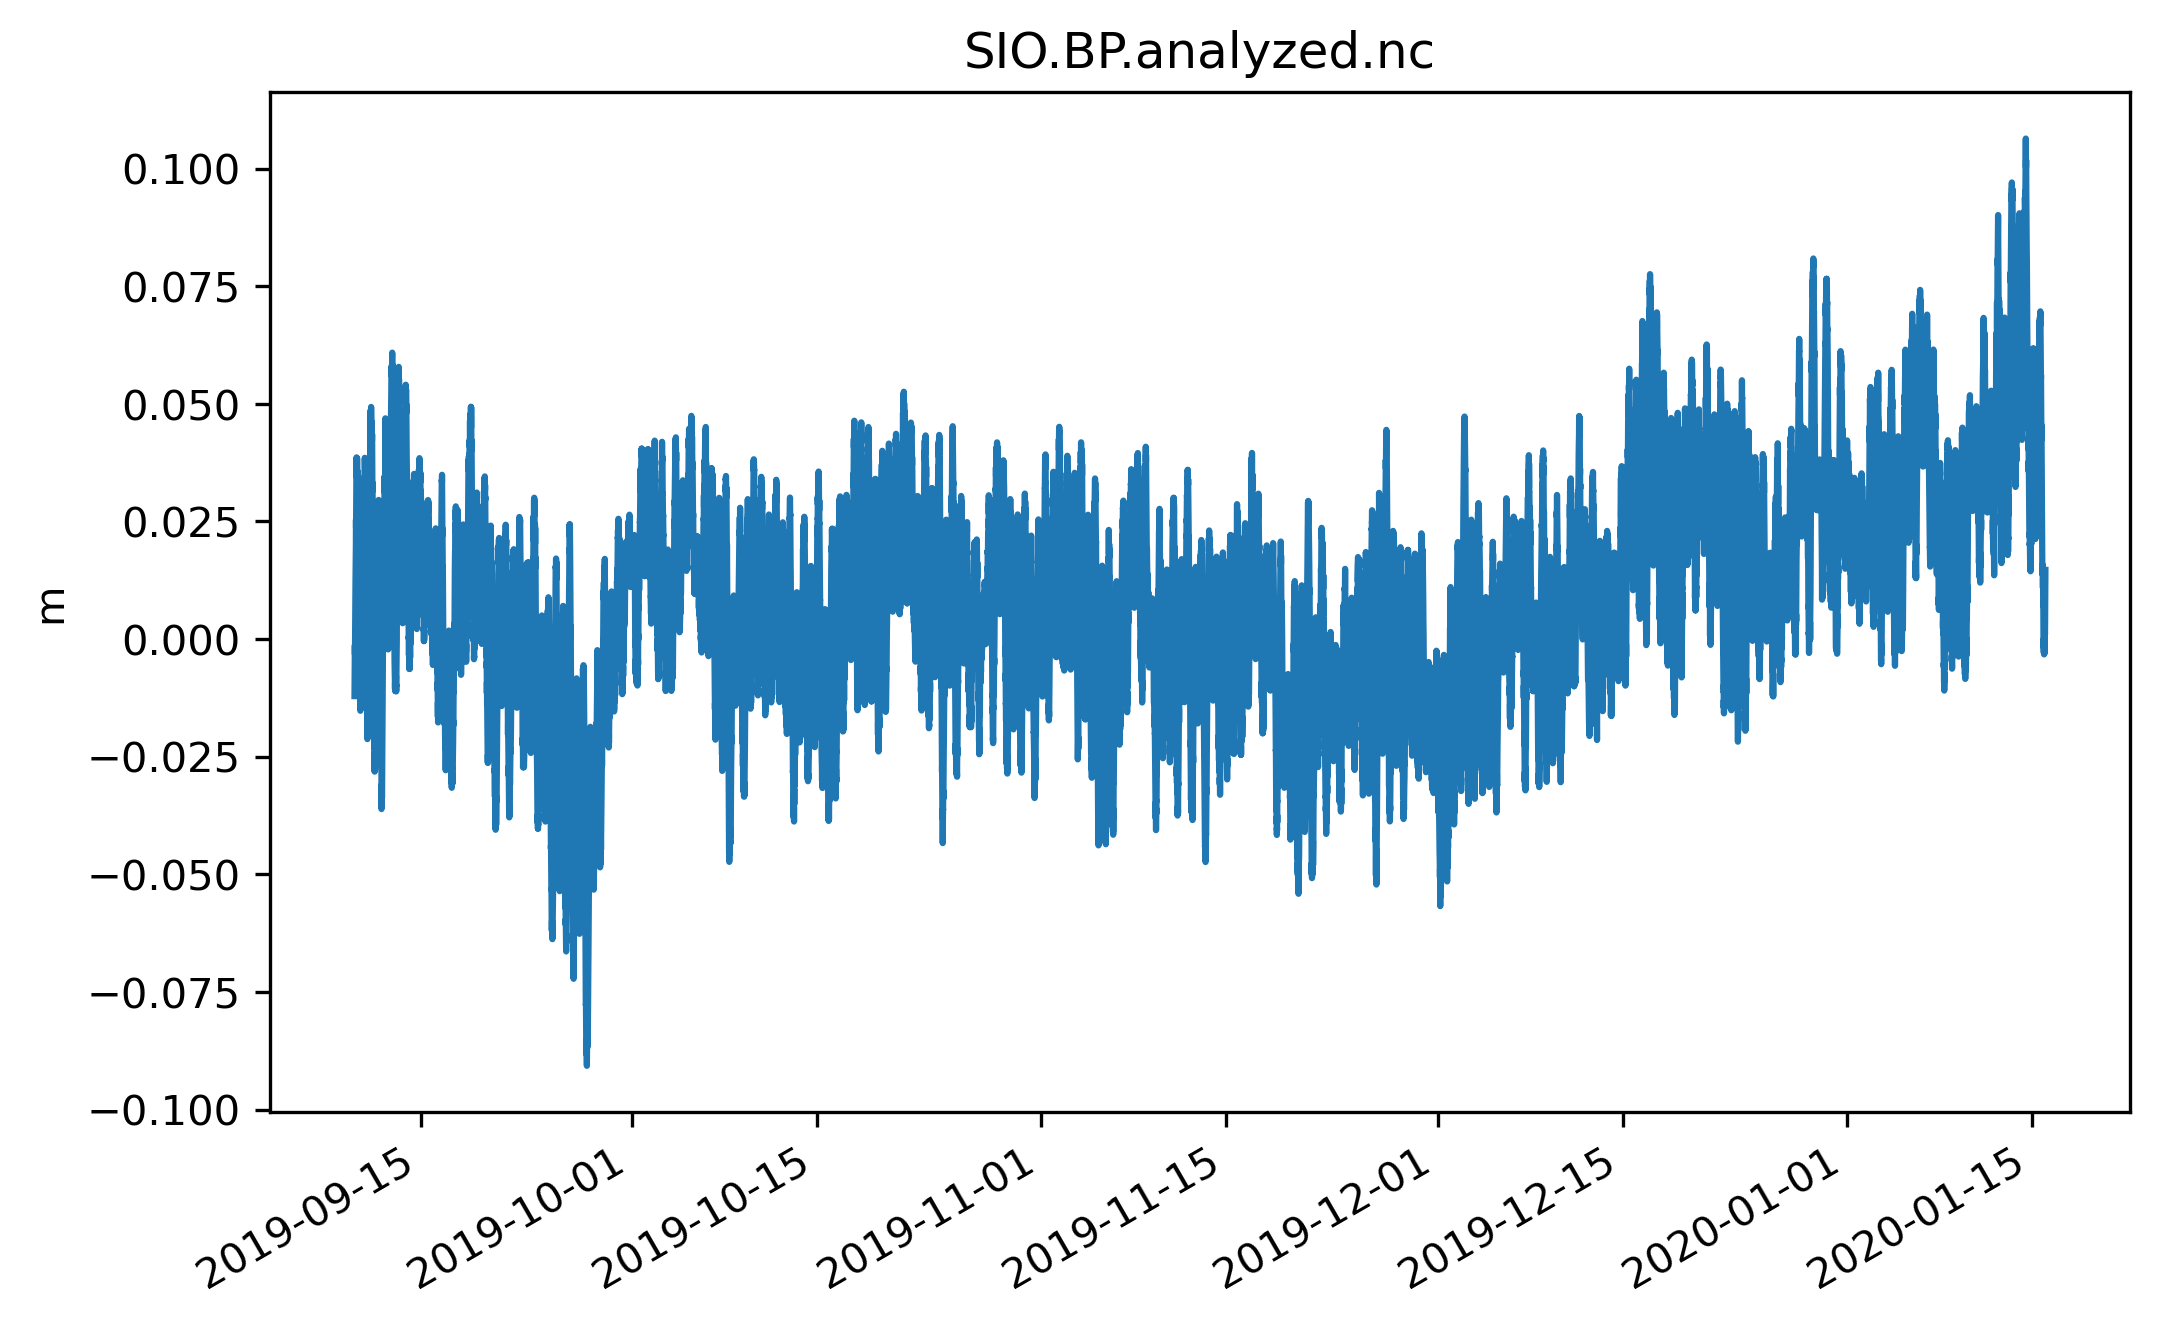

In [10]:
fig, ax = plt.subplots(1, 1)
ax.plot(ds2.time,ds2.bp_detided/1020/9.8-4564.1)
ax.set(ylabel='m')
ax.set_title(file2)

fig.autofmt_xdate()
plt.savefig(__figdir__+'SIO_detided.pdf',**savefig_args)

## Something seems wrong or different between the two BP records

It looks like the SIO record has been corrected for drift and the PMEL record has not.  Try subtracting bp_detided from SEAFLOOR_PRESSURE, as ``ds1['bp_detided2'] = ds1.SEAFLOOR_PRESSURE-ds1.bp_tide``, but that didn't work either.

In [11]:
# spectrum_band_avg(yy,dt,M,winstr=None,plotflag=None,ebarflag=None):
dt=1/60/60/24 # convert from ns to days
M=7
plotflag=True
ebarflag=True
sio_detided = np.array(ds2.bp_detided)/1020/9.8-4564.1
sio_raw = np.array(ds2.bp)/1020/9.8-4564.1
pmel_detided = np.array(ds1.bp_detided)/1020/9.8-4560.1
pmel_raw = np.array(ds1.SEAFLOOR_PRESSURE)/1020/9.8-4560.1


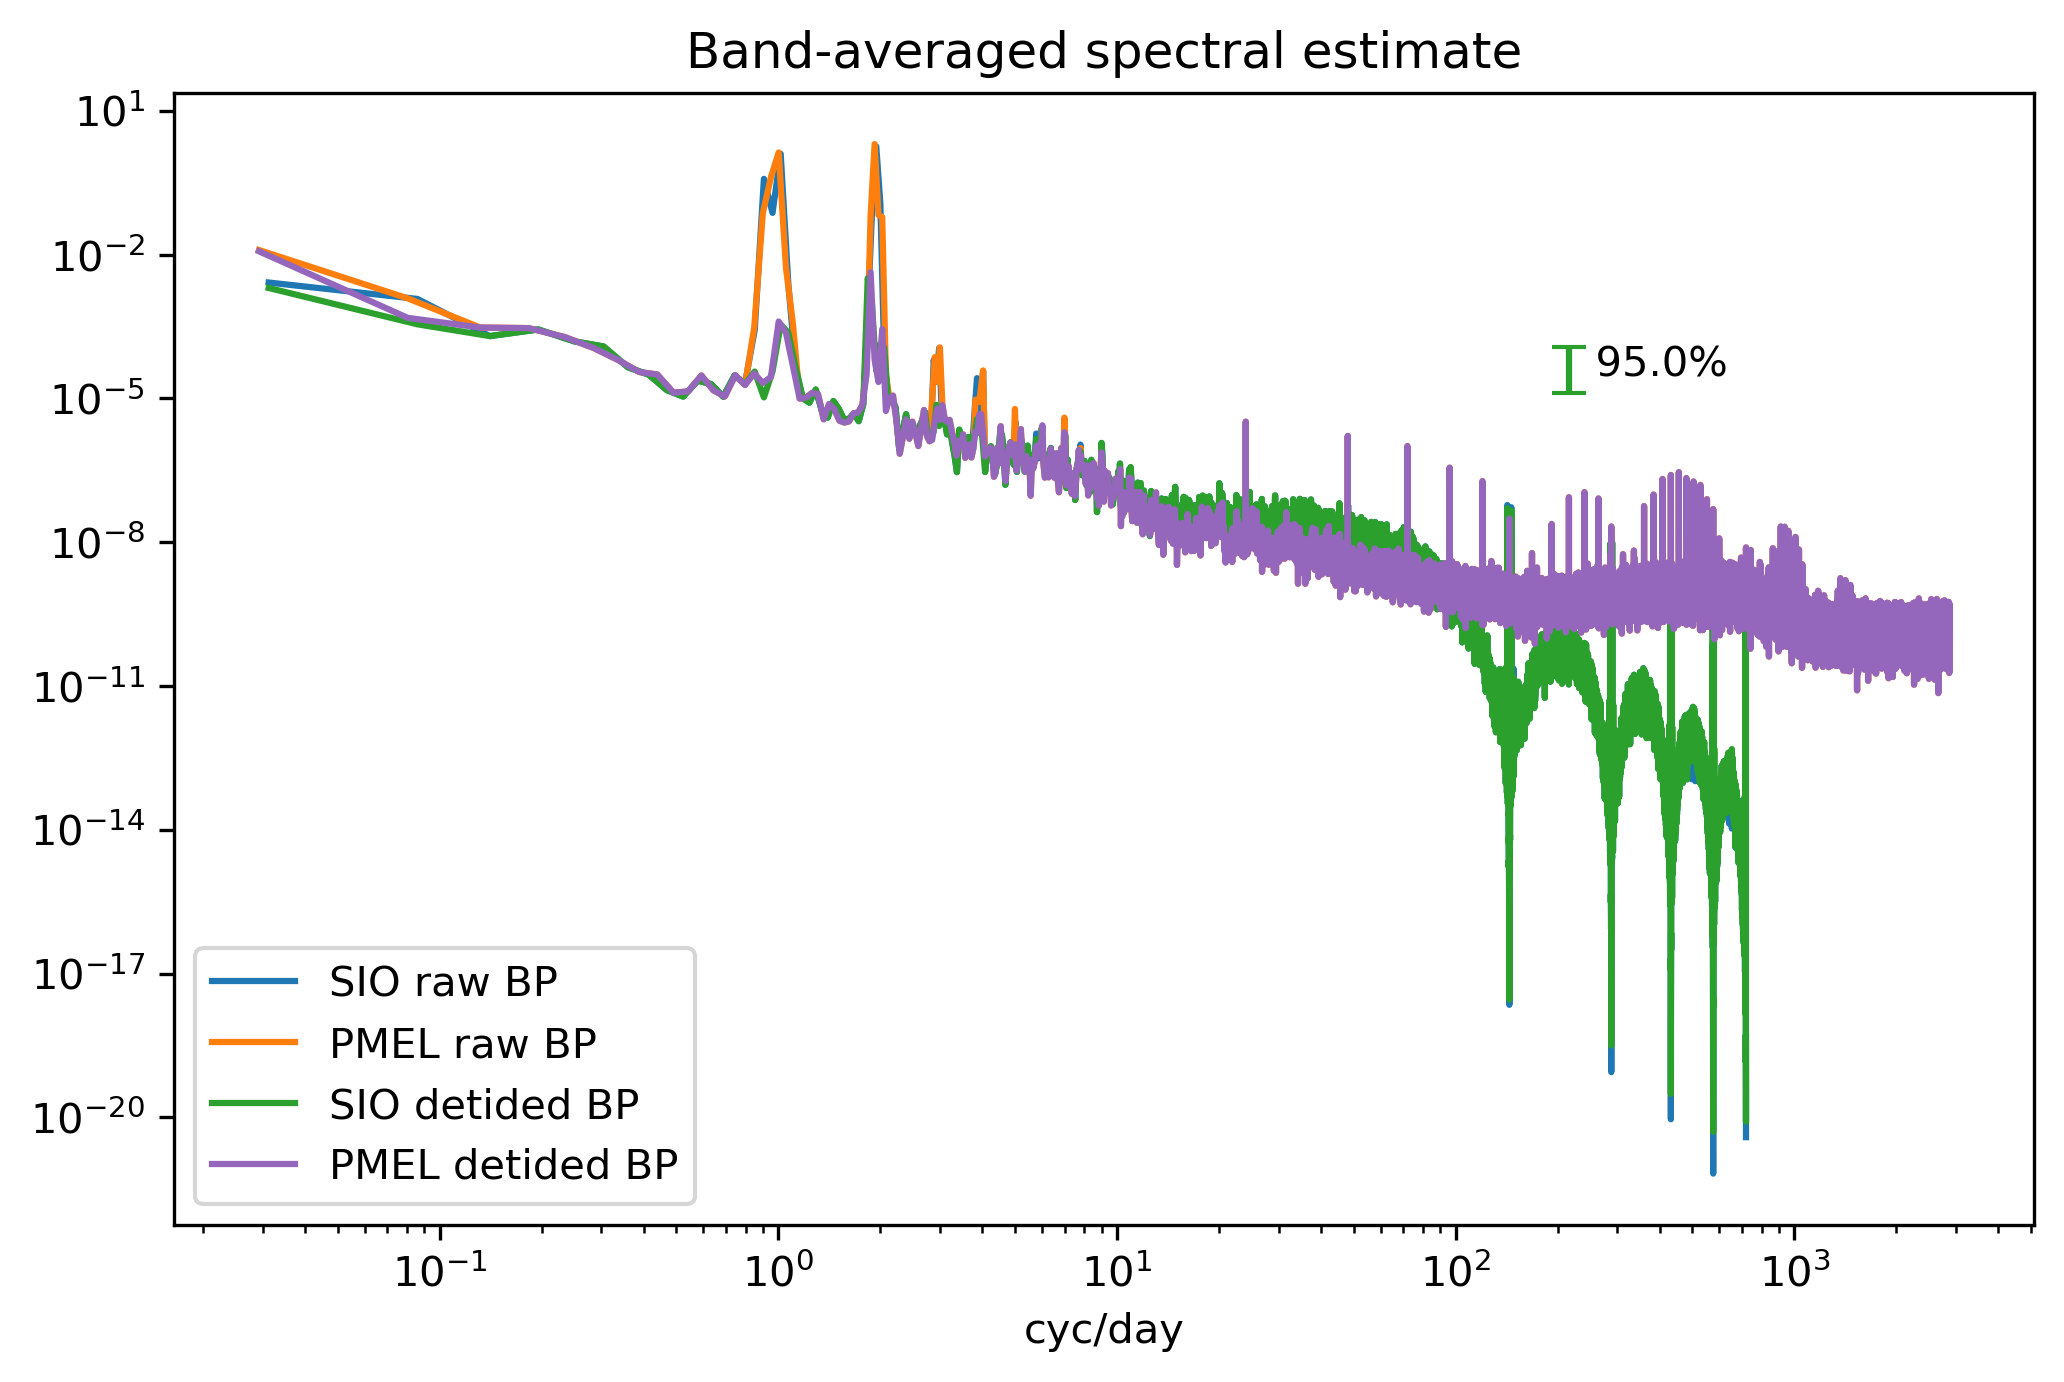

In [12]:
Tom_tools_v1.spectrum_band_avg(sio_raw,dt_sio,M,winstr='hann',plotflag=plotflag,ebarflag=False)
Tom_tools_v1.spectrum_band_avg(pmel_raw,dt_pmel,M,winstr='hann',plotflag=plotflag,ebarflag=False)
Tom_tools_v1.spectrum_band_avg(sio_detided,dt_sio,M,winstr='hann',plotflag=plotflag,ebarflag=ebarflag)
Tom_tools_v1.spectrum_band_avg(pmel_detided,dt_pmel,M,winstr='hann',plotflag=plotflag,ebarflag=False)
plt.legend(['SIO raw BP','PMEL raw BP','SIO detided BP','PMEL detided BP'])
plt.xlabel('cyc/day')
plt.savefig(__figdir__+'spectra.pdf',**savefig_args)

## OK, re-do more like Fig 17 of the paper
Jinbo says he made Fig 17 of the paper without a drift correction on the PMEL bottom pressure; instead, he "started the time series from 09/15/2019".

So, I want to do the following to move forward:
1. Truncate all records to the same start/stop times.
2. Smooth and re-sample to the same time grid
3. Calculate differences
4. Compute/plot spectra
5. Compute/plot variances


In [13]:
ff1=np.where((ds1.time>np.datetime64('2019-09-14')) & (ds1.time<np.datetime64('2020-01-16')))
ff2=np.where((ds2.time>np.datetime64('2019-09-14')) & (ds2.time<np.datetime64('2020-01-16')))

# (time[ffx[0][0]],time[ffx[0][-1]])


In [14]:
time_pmel = ds1.time[ff1[0][:]]
bp_pmel = np.array(ds1.SEAFLOOR_PRESSURE[ff1[0][:]])/1020/9.8
bp_detided_pmel = np.array(ds1.bp_detided[ff1[0][:]])/1020/9.8
bp_tide_pmel = np.array(ds1.bp_tide[ff1[0][:]])/1020/9.8

time_sio = ds2.time[ff2[0][:]]
bp_sio = np.array(ds2.bp[ff2[0][:]])/1020/9.8
bp_detided_sio = np.array(ds2.bp_detided[ff2[0][:]])/1020/9.8
bp_tide_sio = np.array(ds2.bp_tide[ff2[0][:]])/1020/9.8

# detrend (and demean)
bp_detided_pmel = signal.detrend(bp_detided_pmel)
bp_detided_sio = signal.detrend(bp_detided_sio)

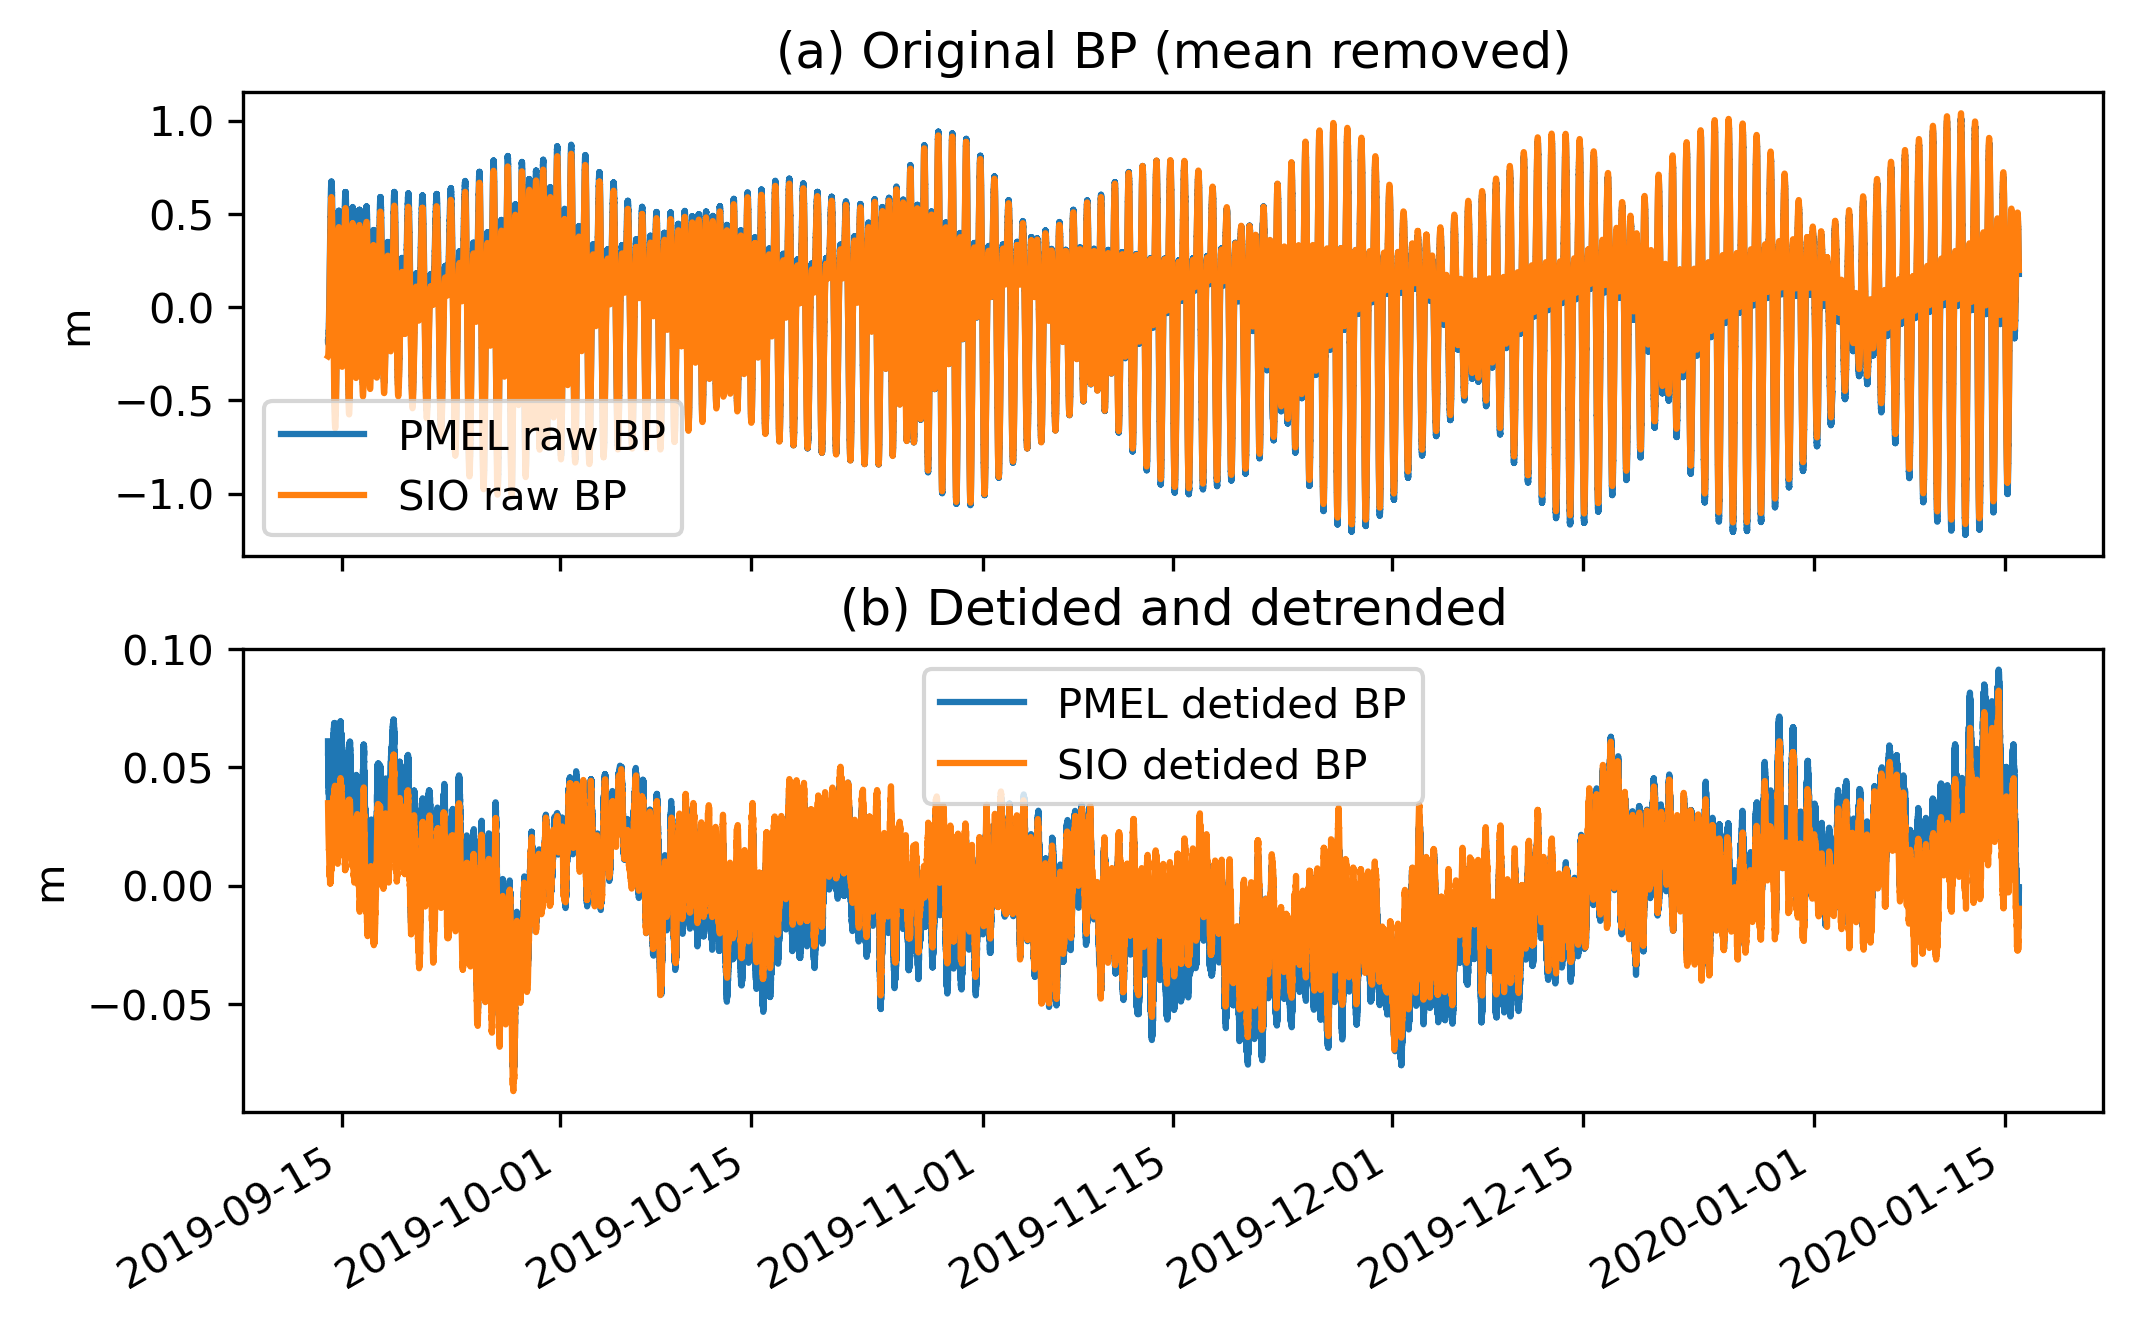

In [15]:
fig, ax = plt.subplots(2, 1)
raw = 0
detided = 1
ax[raw].plot(time_pmel,bp_pmel-np.mean(bp_pmel))
ax[raw].plot(time_sio,bp_sio-np.mean(bp_sio))
ax[raw].set(ylabel='m')
ax[raw].legend(['PMEL raw BP','SIO raw BP'])
ax[raw].set_title('(a) Original BP (mean removed)')

ax[detided].plot(time_pmel,bp_detided_pmel)
ax[detided].plot(time_sio,bp_detided_sio)
ax[detided].set(ylabel='m')
ax[detided].legend(['PMEL detided BP','SIO detided BP'])
ax[detided].set_title('(b) Detided and detrended')

fig.autofmt_xdate()
# plt.savefig(__figdir__+'SIO_detided.pdf',**savefig_args)

In [16]:
std_pmel=np.std(bp_detided_pmel)
std_sio=np.std(bp_detided_sio)

In [17]:
std_pmel

0.02659635387357684

In [18]:
std_sio

0.023146757395885693

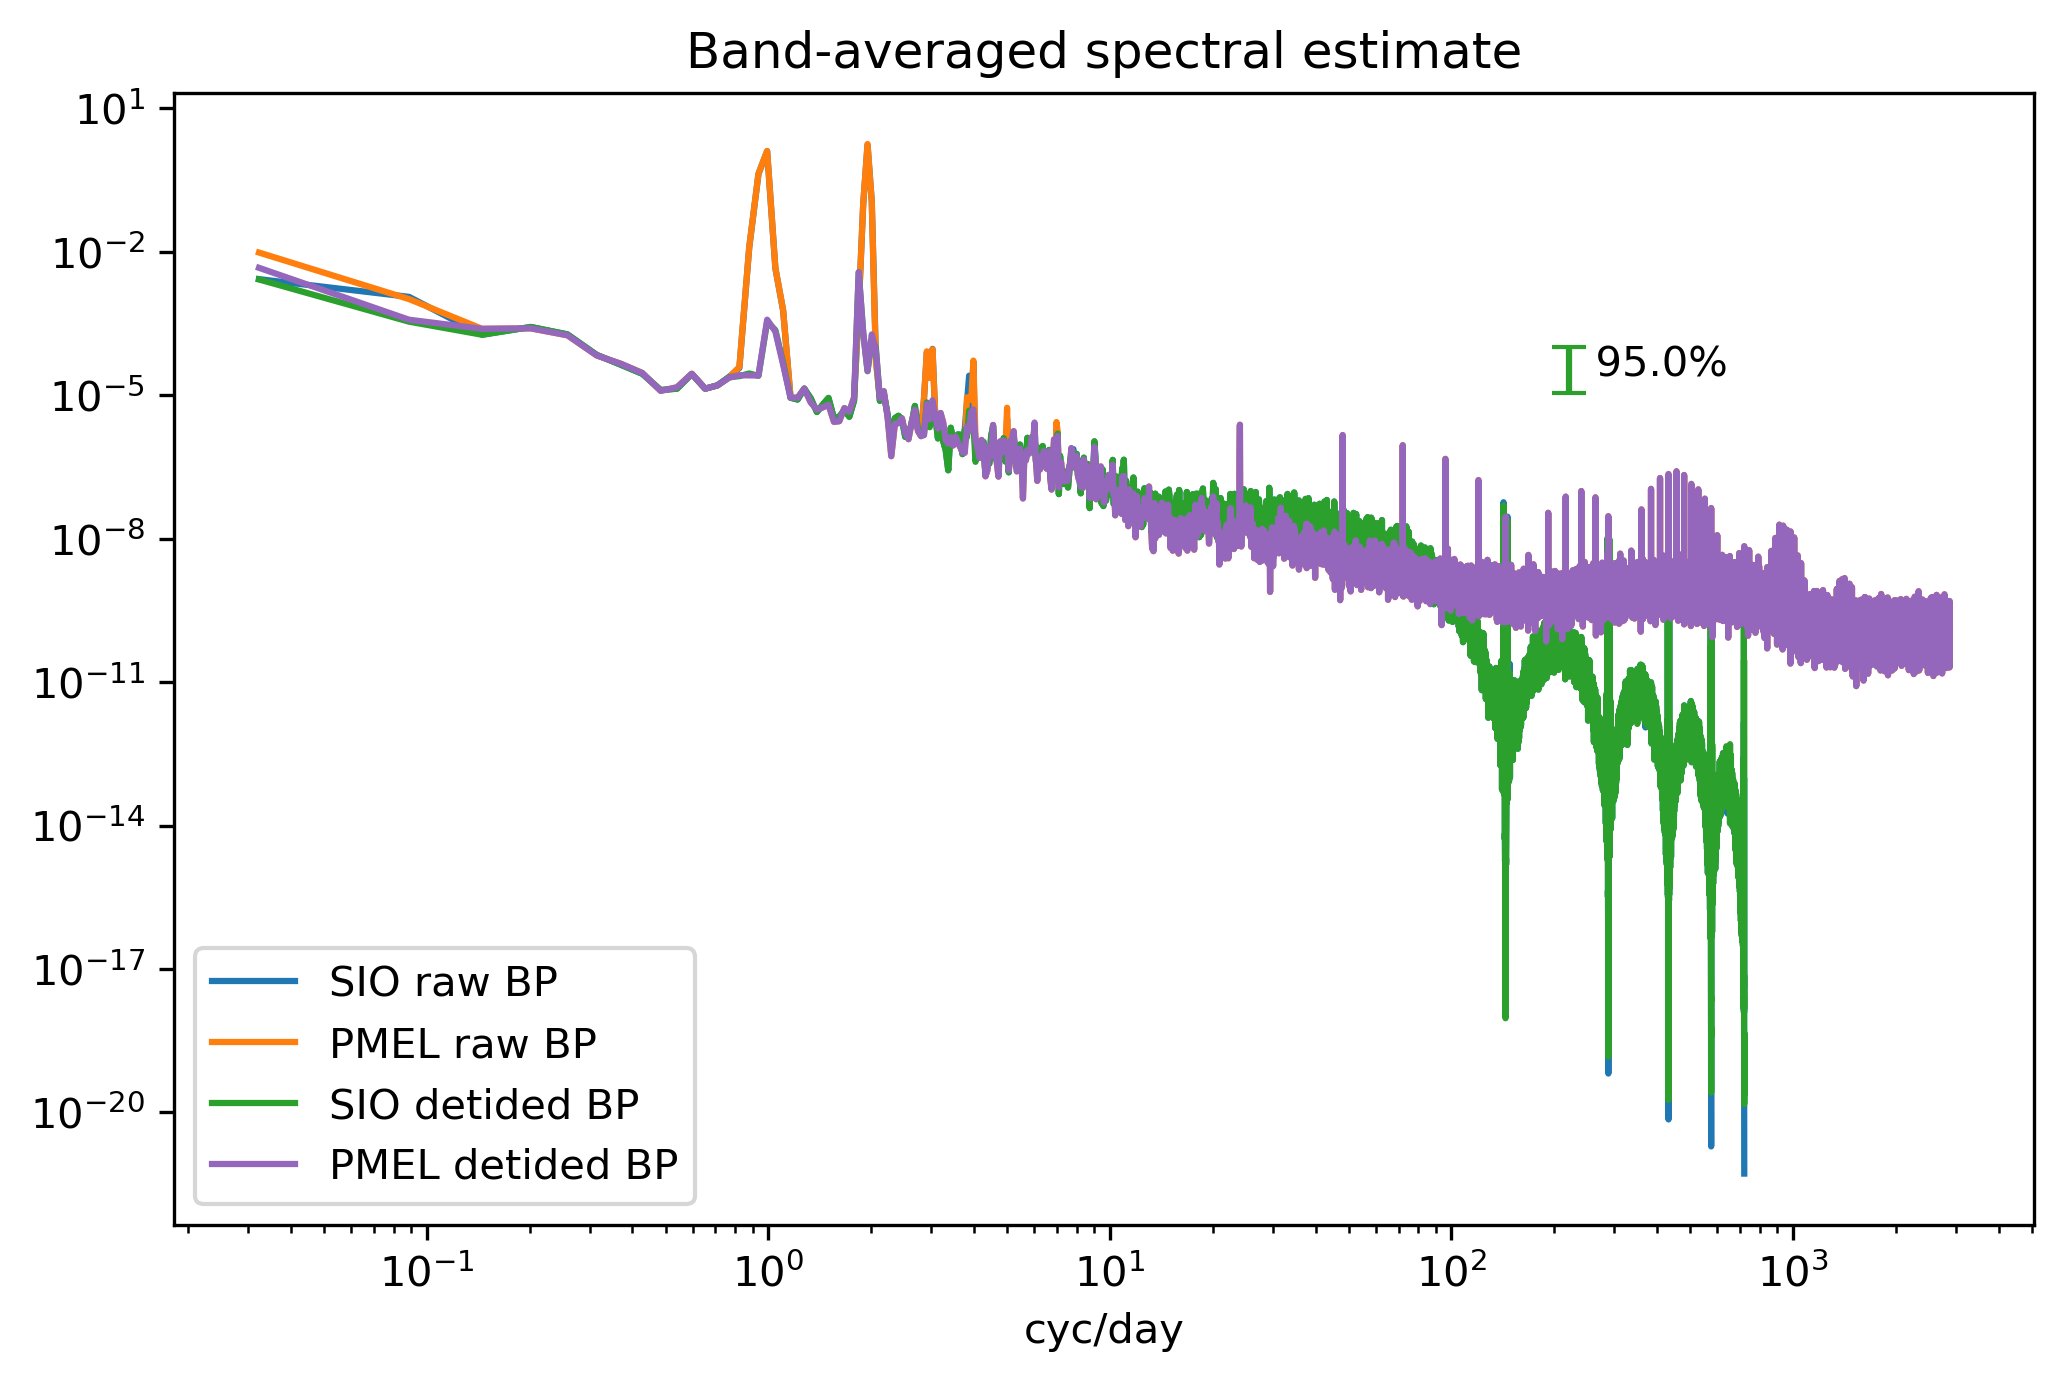

In [19]:
Tom_tools_v1.spectrum_band_avg(bp_sio,dt_sio,M,winstr='hann',plotflag=plotflag,ebarflag=False)
Tom_tools_v1.spectrum_band_avg(bp_pmel,dt_pmel,M,winstr='hann',plotflag=plotflag,ebarflag=False)
Tom_tools_v1.spectrum_band_avg(bp_detided_sio,dt_sio,M,winstr='hann',plotflag=plotflag,ebarflag=ebarflag)
Tom_tools_v1.spectrum_band_avg(bp_detided_pmel,dt_pmel,M,winstr='hann',plotflag=plotflag,ebarflag=False)
plt.legend(['SIO raw BP','PMEL raw BP','SIO detided BP','PMEL detided BP'])
plt.xlabel('cyc/day')
plt.savefig(__figdir__+'spectra.pdf',**savefig_args)

In [20]:
print('PMEL is ' + str(dt_pmel*24*60) + ' samples per minute')
print('SIO is ' + str(dt_sio*24*60) + ' samples per minute')

PMEL is 0.25 samples per minute
SIO is 1.0 samples per minute


SIO dt is 1 minute (interpolated from 10 min) and PMEL dt is 15s.  There is some sort of wierd spiking in PMEL record at 1 cph. I'm going to smooth both to ~1 h.

In [21]:
bp_detided_sio_low=Tom_tools_v1.run_avg1d(bp_detided_sio,int(60/(dt_sio*24*60))) 
#(dt_sio*24*60) is number of samples/minute
bp_detided_pmel_low=Tom_tools_v1.run_avg1d(bp_detided_pmel,int(60/(dt_pmel*24*60))) 
#(dt_pmel*24*60) is number of samples/minute

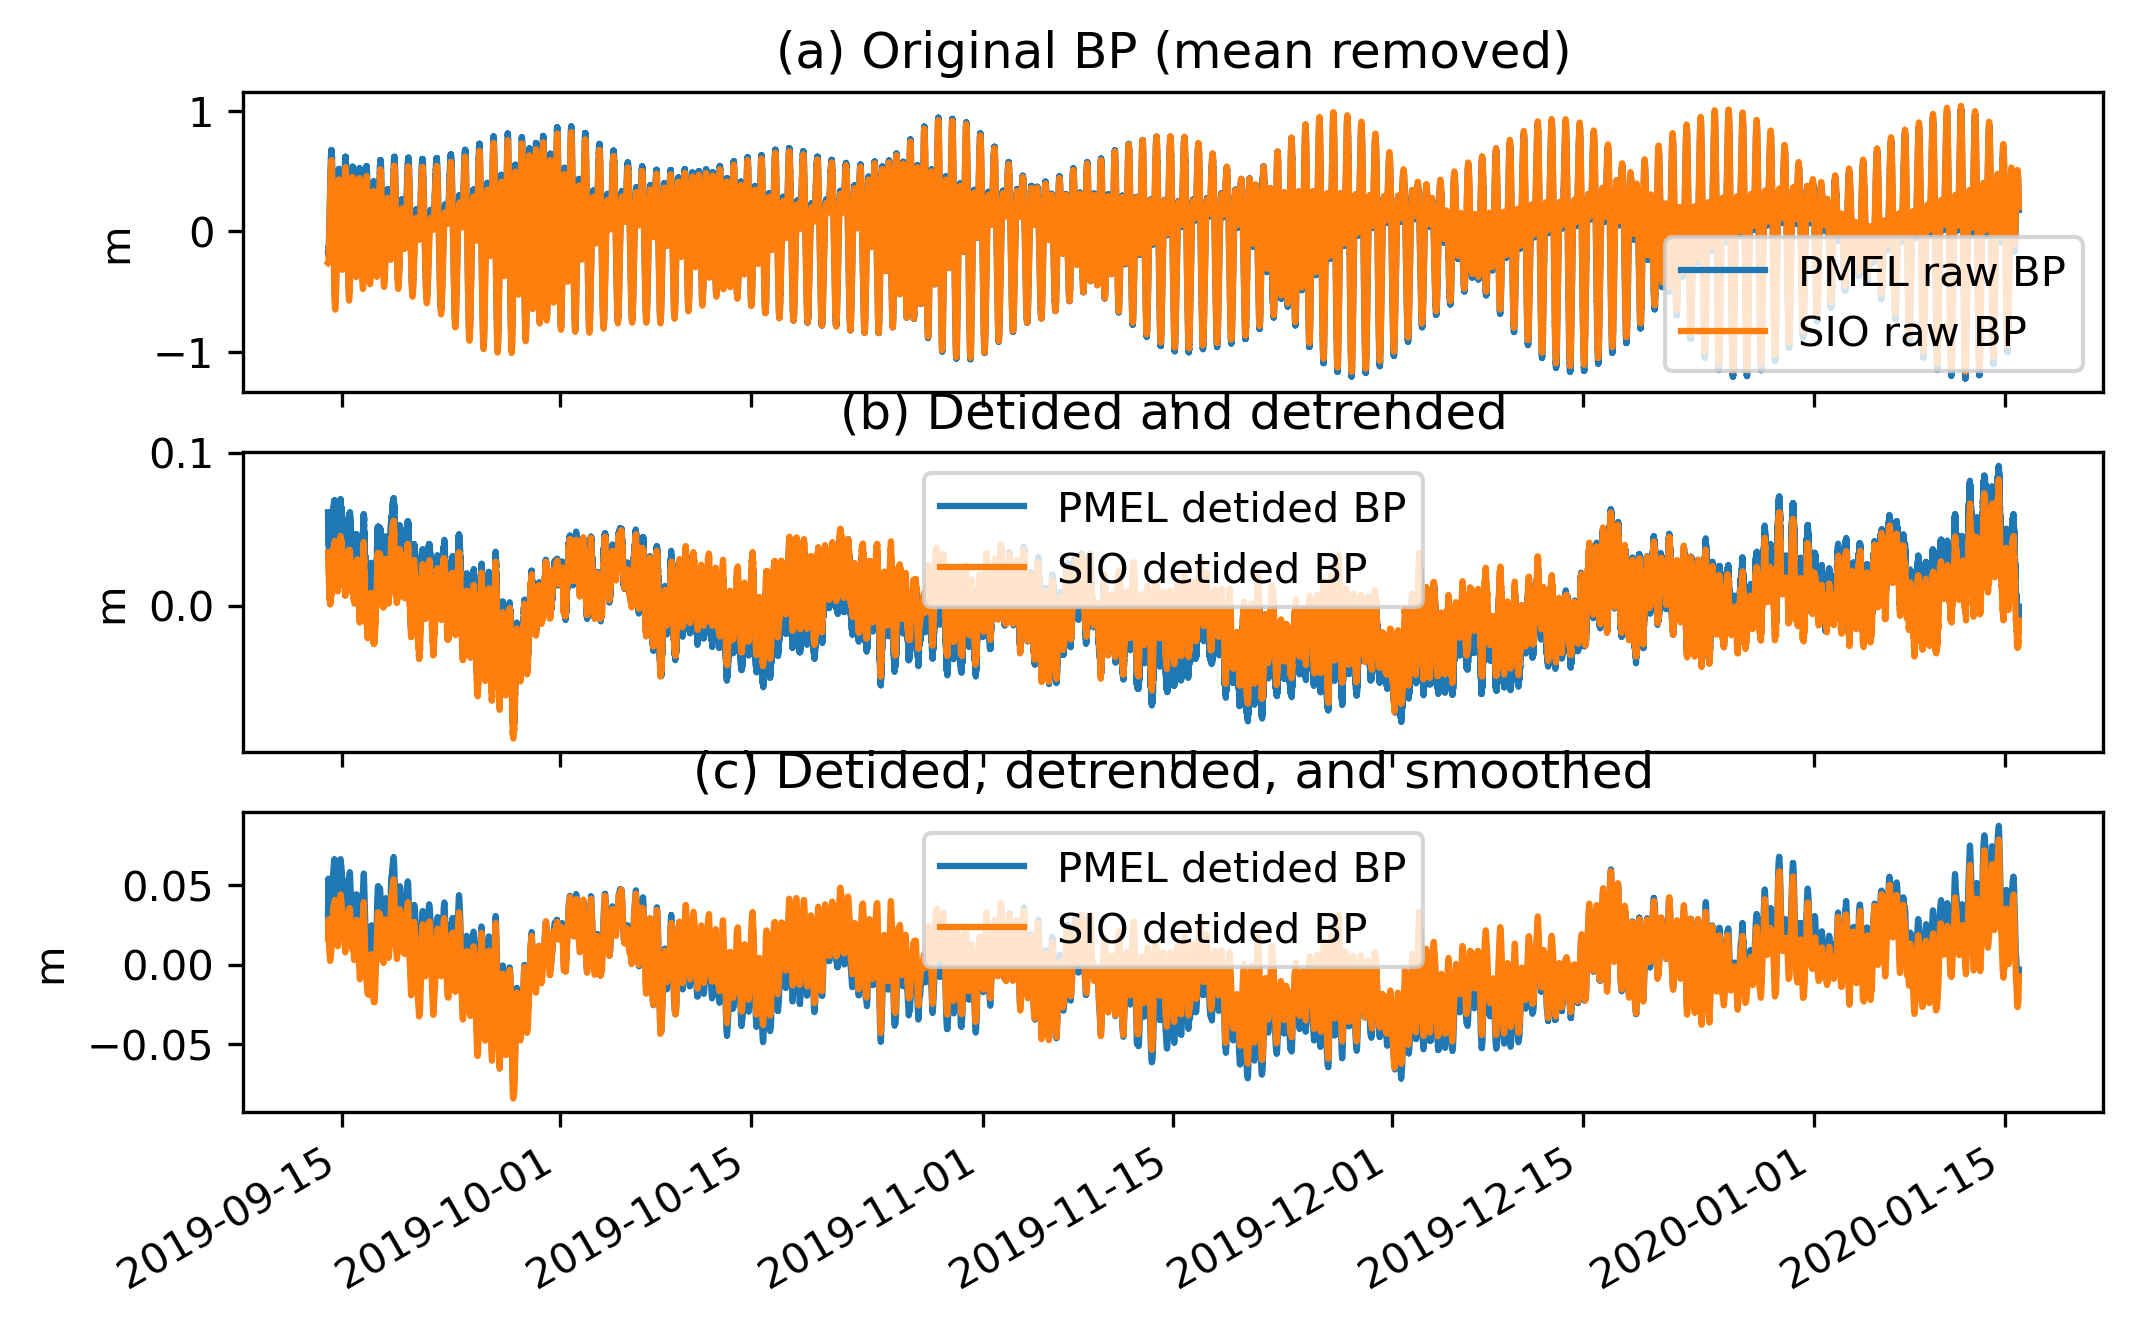

In [22]:
# wx, gtk, osx, tk, empty uses default
fig, ax = plt.subplots(3, 1)
raw = 0
detided = 1
filtered = 2
ax[raw].plot(time_pmel,bp_pmel-np.mean(bp_pmel))
ax[raw].plot(time_sio,bp_sio-np.mean(bp_sio))
ax[raw].set(ylabel='m')
ax[raw].legend(['PMEL raw BP','SIO raw BP'])
ax[raw].set_title('(a) Original BP (mean removed)')

ax[detided].plot(time_pmel,bp_detided_pmel)
ax[detided].plot(time_sio,bp_detided_sio)
ax[detided].set(ylabel='m')
ax[detided].legend(['PMEL detided BP','SIO detided BP'])
ax[detided].set_title('(b) Detided and detrended')

ax[filtered].plot(time_pmel,bp_detided_pmel_low)
ax[filtered].plot(time_sio,bp_detided_sio_low)
ax[filtered].set(ylabel='m')
ax[filtered].legend(['PMEL detided BP','SIO detided BP'])
ax[filtered].set_title('(c) Detided, detrended, and smoothed')


fig.autofmt_xdate()
# plt.savefig(__figdir__+'SIO_detided.pdf',**savefig_args)

In [23]:
np.shape(time_sio)

(178559,)

In [24]:
np.shape(bp_detided_sio_low)

(178559,)

In [25]:
np.shape(bp_detided_sio)

(178559,)

In [26]:
std_pmel=np.std(bp_detided_pmel_low)
std_sio=np.std(bp_detided_sio_low)
print('SIO std = ' + str(std_sio))
print('PMEL std = ' + str(std_pmel))

SIO std = 0.022981938775504588
PMEL std = 0.026440482479557915


In [27]:
time_sio[0]

<xarray.DataArray 'time' ()>
array('2019-09-14T00:01:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-09-14T00:01:00

In [28]:
time_pmel[0]

<xarray.DataArray 'time' ()>
array('2019-09-14T00:00:15.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-09-14T00:00:15

In [29]:
# Find common times
time_common, p_ind, s_ind = np.intersect1d(time_pmel, time_sio, return_indices=True)
bp_detided_pmel_low_common = bp_detided_pmel_low[p_ind]
bp_detided_sio_low_common = bp_detided_sio_low[s_ind]
bp_diff = bp_detided_pmel_low_common-bp_detided_sio_low_common

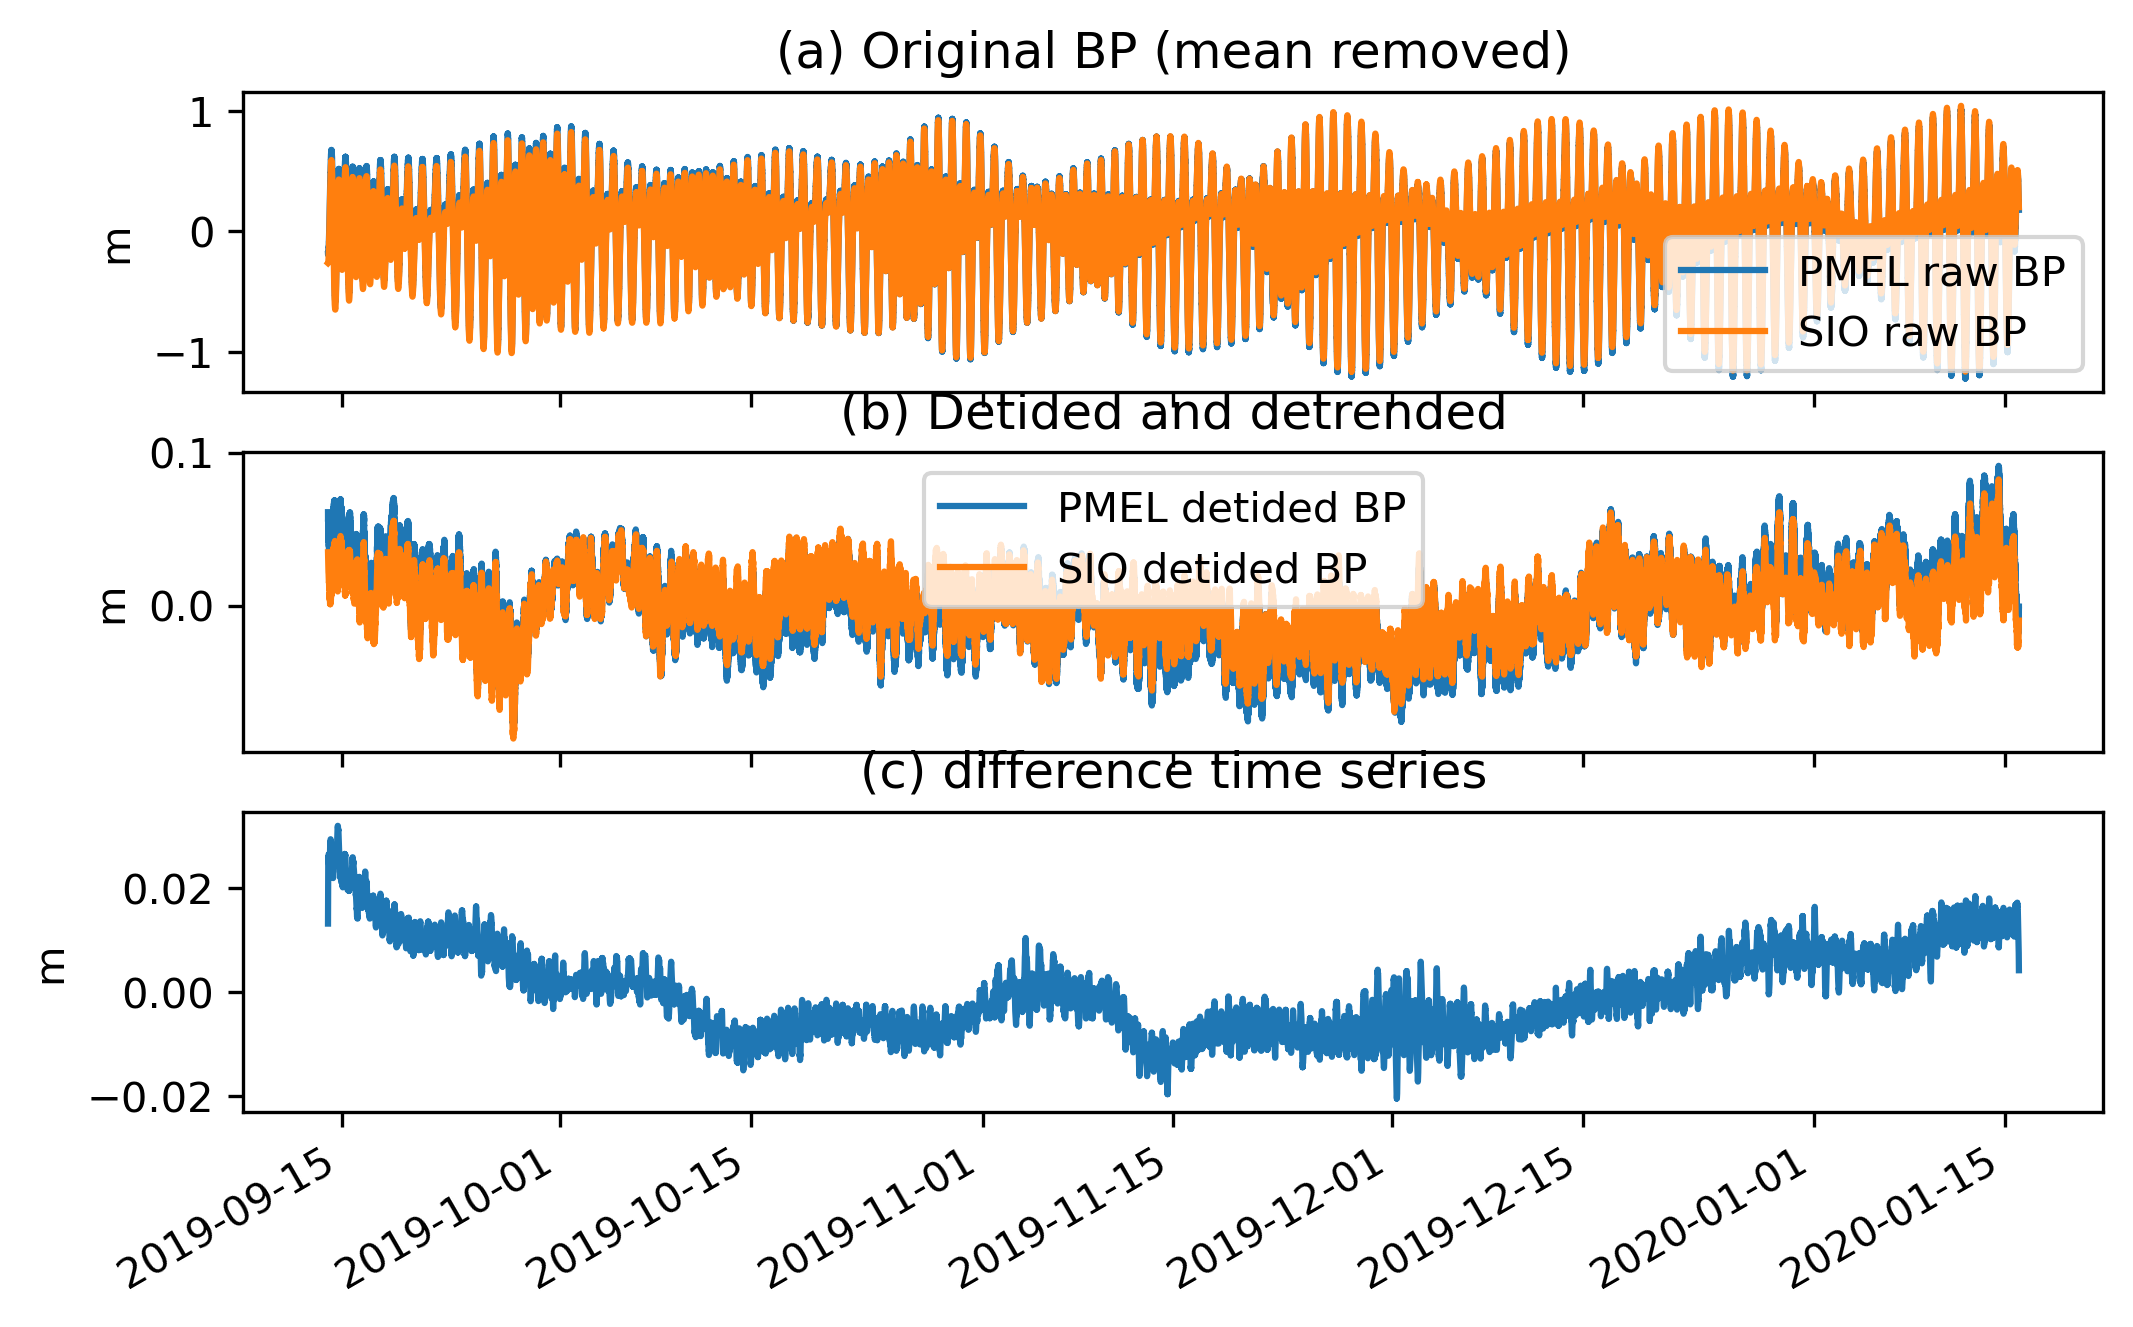

In [30]:
fig, ax = plt.subplots(3, 1)
raw = 0
detided = 1
filtered = 2
ax[raw].plot(time_pmel,bp_pmel-np.mean(bp_pmel))
ax[raw].plot(time_sio,bp_sio-np.mean(bp_sio))
ax[raw].set(ylabel='m')
ax[raw].legend(['PMEL raw BP','SIO raw BP'])
ax[raw].set_title('(a) Original BP (mean removed)')

ax[detided].plot(time_pmel,bp_detided_pmel)
ax[detided].plot(time_sio,bp_detided_sio)
ax[detided].set(ylabel='m')
ax[detided].legend(['PMEL detided BP','SIO detided BP'])
ax[detided].set_title('(b) Detided and detrended')

ax[filtered].plot(time_common,bp_diff)
ax[filtered].set(ylabel='m')
ax[filtered].set_title('(c) difference time series')


fig.autofmt_xdate()
# plt.savefig(__figdir__+'SIO_detided.pdf',**savefig_args)

In [31]:
std_diff=np.std(bp_diff)
print('Std dev of SIO-PMEL diff = ' + str(std_diff))

Std dev of SIO-PMEL diff = 0.00838217012283143


## Well, that looks like the variance of the difference is dominated by the long-term drift (see panel c above).

In [32]:
# pfit = np.poly1d(np.polynomial.polynomial.Polynomial.fit(np.linspace(0,100,len(bp_diff)), bp_diff, 3))
tfoo = np.linspace(0,100,len(bp_diff))
pfit = np.poly1d(np.polyfit(tfoo, bp_diff, 2))
bp_diff_fit = pfit(tfoo)

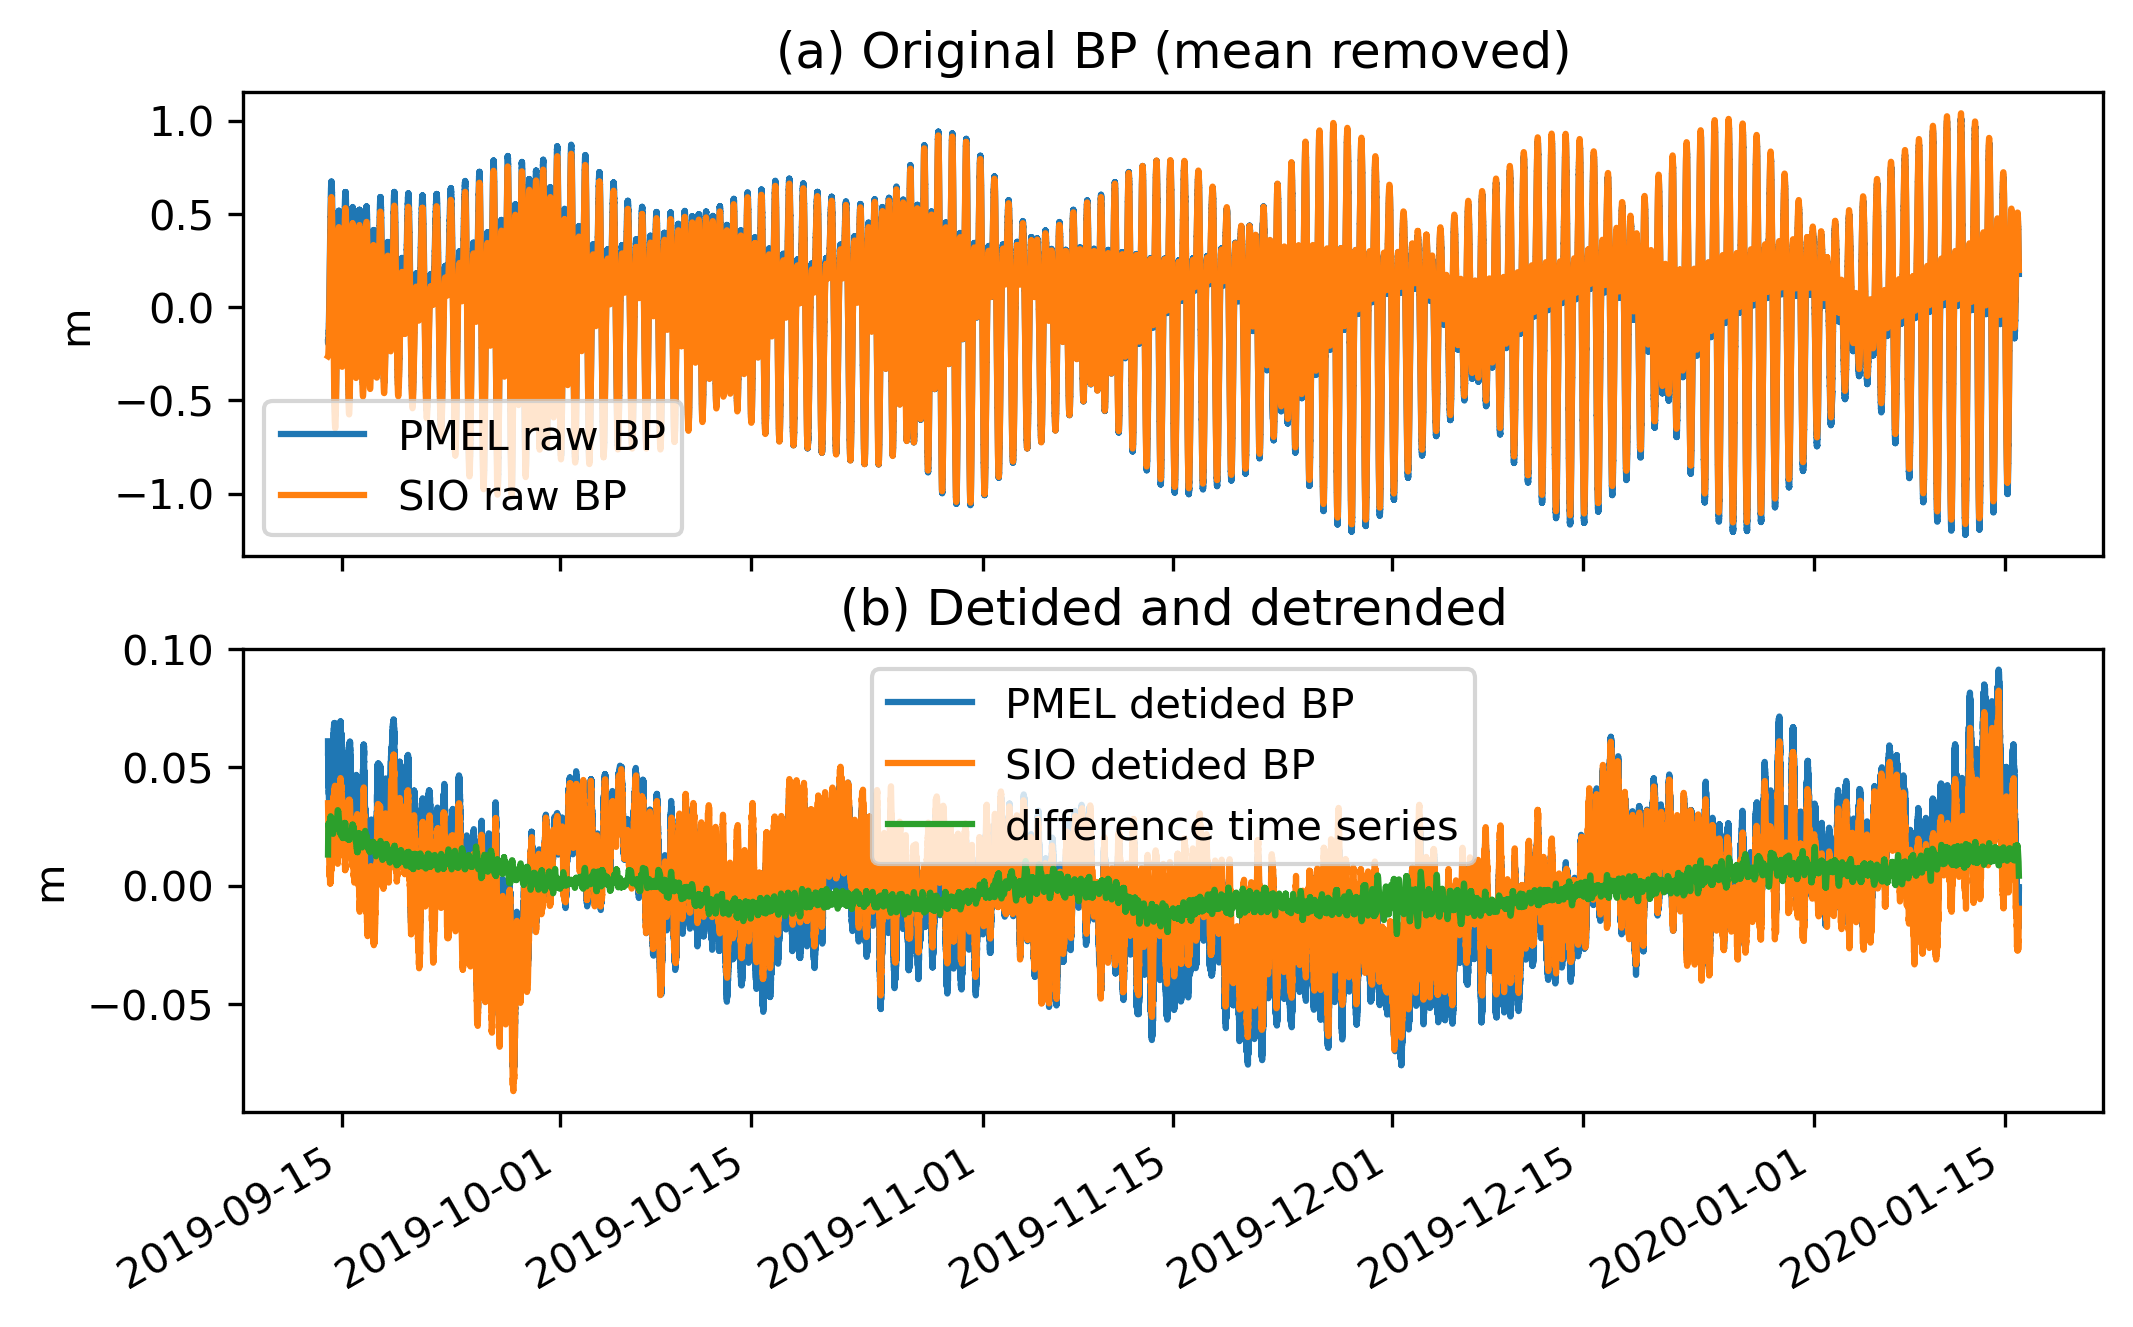

In [38]:
fig, ax = plt.subplots(2, 1)
raw = 0
detided = 1
filtered = 2
ax[raw].plot(time_pmel,bp_pmel-np.mean(bp_pmel))
ax[raw].plot(time_sio,bp_sio-np.mean(bp_sio))
ax[raw].set(ylabel='m')
ax[raw].legend(['PMEL raw BP','SIO raw BP'])
ax[raw].set_title('(a) Original BP (mean removed)')

ax[detided].plot(time_pmel,bp_detided_pmel)
ax[detided].plot(time_sio,bp_detided_sio)
ax[detided].plot(time_common,bp_diff)
ax[detided].set(ylabel='m')
ax[detided].legend(['PMEL detided BP','SIO detided BP','difference time series'])
ax[detided].set_title('(b) Detided and detrended')


fig.autofmt_xdate()
# plt.savefig(__figdir__+'revised_Fig_17',**savefig_args)

In [34]:
std_diff=np.std(bp_diff)
print('Std dev of SIO-PMEL diff = ' + str(std_diff) + ' m')
std_detrend_diff=np.std(bp_diff-bp_diff_fit)
print('Std dev of SIO-PMEL diff after removal of 2nd-order polynomial fit = ' + str(std_detrend_diff) + ' m')

Std dev of SIO-PMEL diff = 0.00838217012283143 m
Std dev of SIO-PMEL diff after removal of 2nd-order polynomial fit = 0.004280468779719776 m


In [35]:
pfit

poly1d([ 9.66886527e-06, -9.66838106e-04,  1.61108172e-02])

In [36]:
time_common[0:2]

array(['2019-09-14T00:01:00.000000000', '2019-09-14T00:02:00.000000000'],
      dtype='datetime64[ns]')

Text(0.5, 0, 'cyc/day')

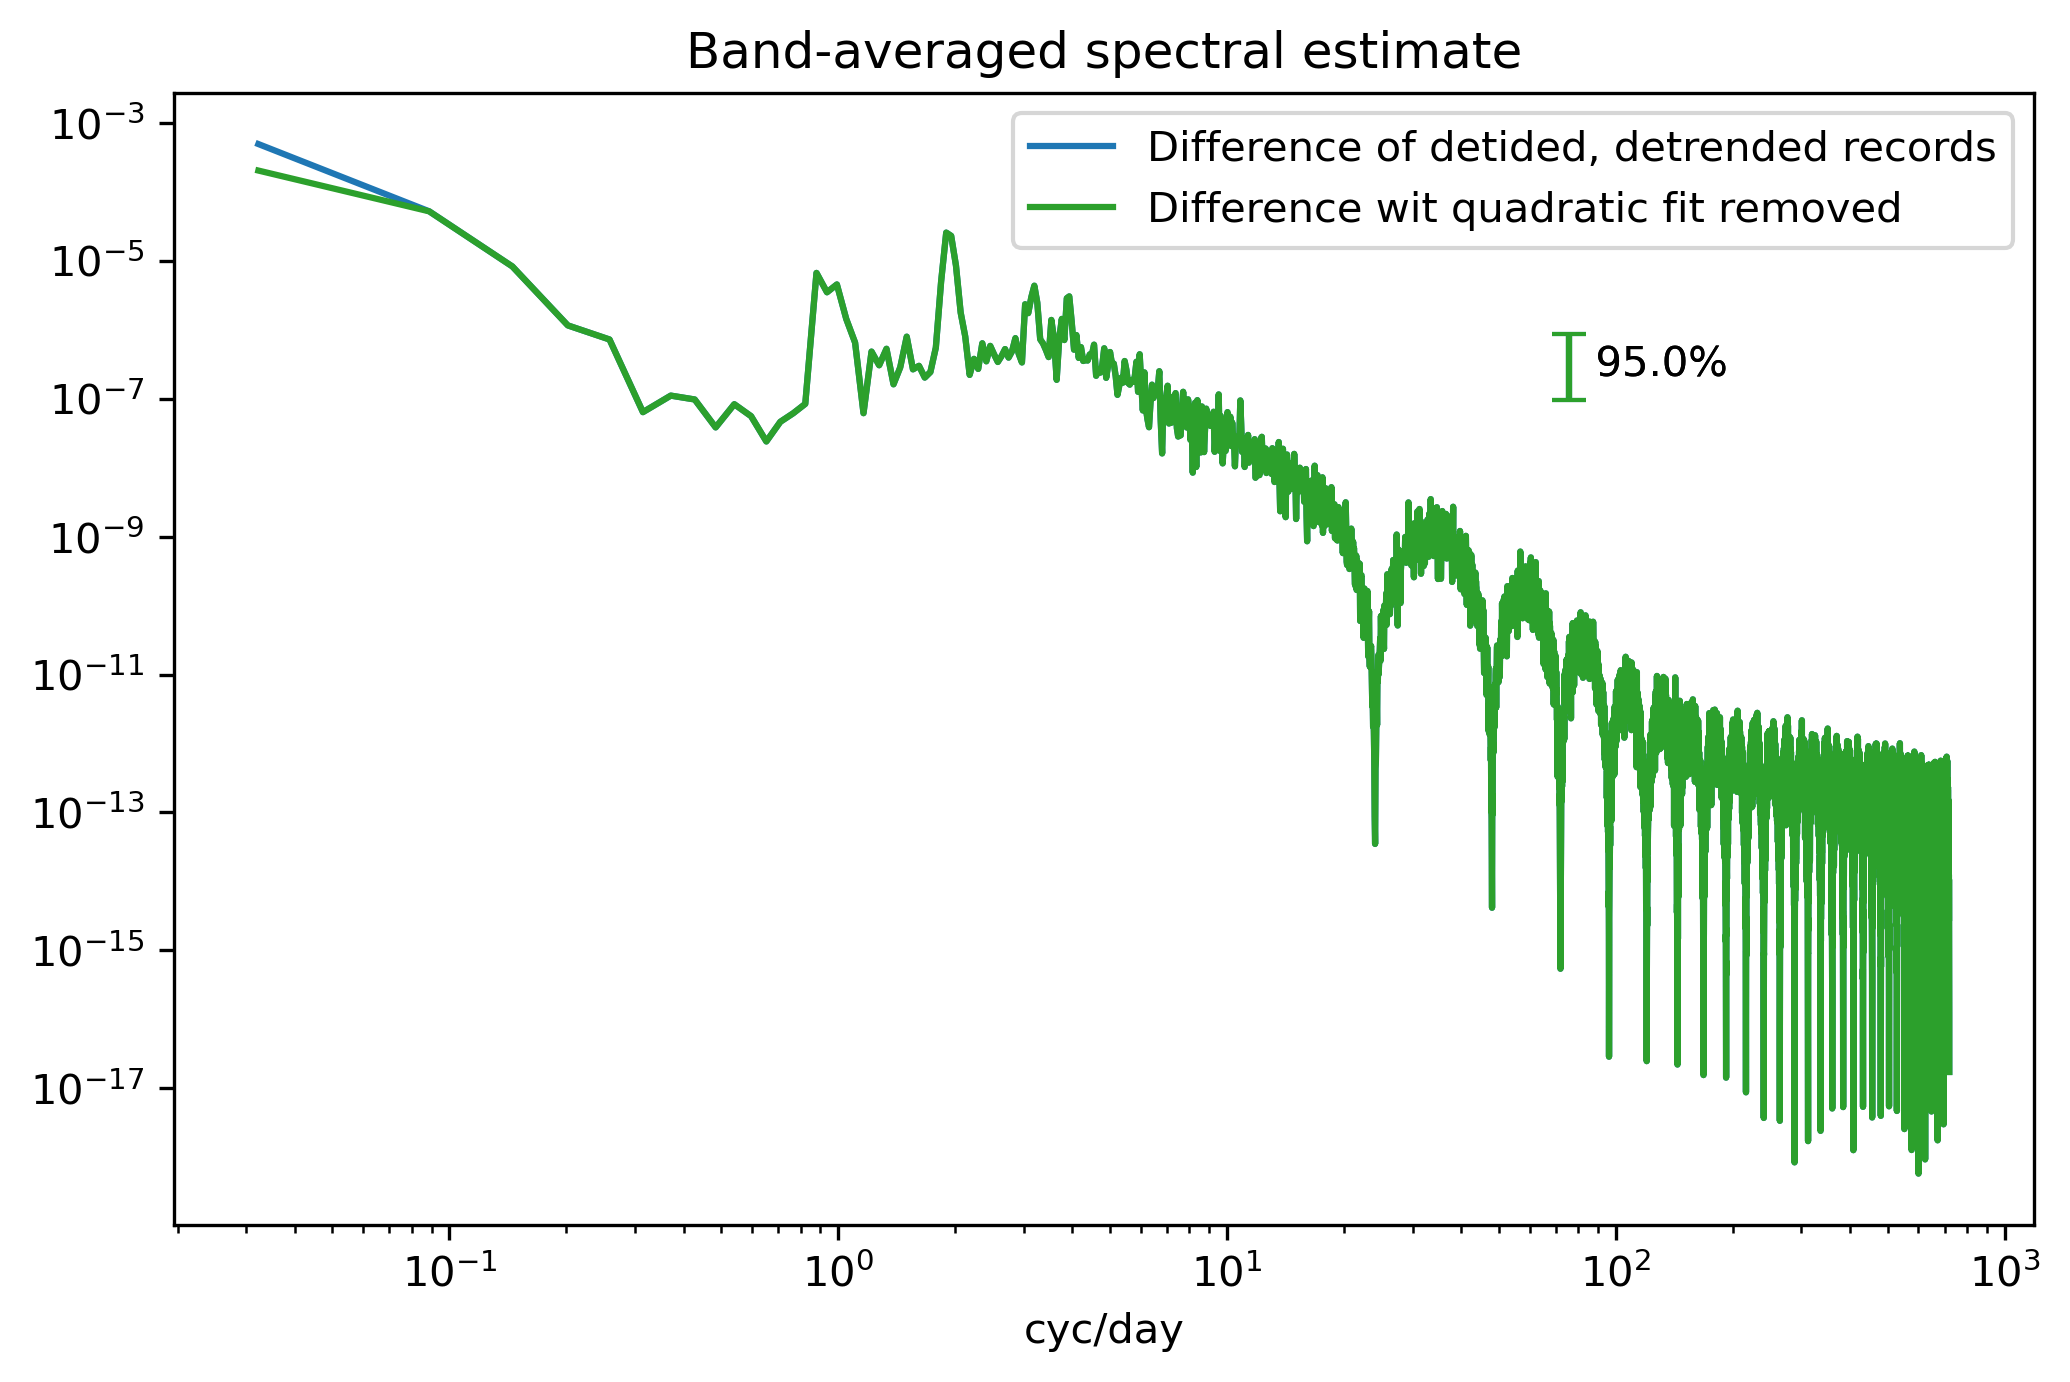

In [37]:
# %matplotlib qt
fig, ax = plt.subplots(1, 1)
Tom_tools_v1.spectrum_band_avg(bp_diff,1/(24*60),M,winstr='hann',plotflag=plotflag,ebarflag=ebarflag)
Tom_tools_v1.spectrum_band_avg(bp_diff-bp_diff_fit,1/(24*60),M,winstr='hann',plotflag=plotflag,ebarflag=None)
plt.legend(['Difference of detided, detrended records','Difference wit quadratic fit removed'])
plt.xlabel('cyc/day')


## Notice that the residual contains diurnal and semidiurnal tidal peaks, as well as at 3- and 4-cpd harmonics (roughly 1, 2, 3, 4 times/day).

# Given all of the above, here is proposed text for Section 4.7 "Bottom Pressure"

Bottom pressure recorders measure both the barotropic and baroclinic signals on the ocean floor. The BPRs deployed in this campaign have enough precision to detect mm-level signals, but BPRs suffer from a large long-term drift that may be mistaken for a low-frequency signal in our ~90-day records. Ray (2013) analyzed a network of BPRs of this type, showing that BPR-derived tide matches the altimetric tide model with about 5 mm RMS difference for the M2 constituent. The BPRs used in the campaign should be accurate enough to detect deep baroclinic pressure signals. The most prominent signal in the bottom pressure is the tide (Figure 17a). We fit 53 tidal constituents to the measured bottom-pressure signal to produce a detided bottom pressure record (Figure 17b). The detided signals are relatively small (2.3–2.6 cm), but still potentially important.  Unfortunately, we have little information about the spatial scale of the signals contributing to these residual bottom pressure signals.  Taking the difference between the two detided bottom-pressure records can give us a vague sense of how small-scale signals might contribute. This difference has an RMS amplitude of 0.8 cm.  It contains both barotropic and baroclinic signals, including several tidal frequencies and low-frequency variability, and the parabolic shape of the difference curve (Figure 17b) suggests it may also be affected by differences in the low-frequency drift of the two bottom pressure recorders.  Removing a quadratic fit to the difference between the two detided bottom-pressure records reduces the RMS difference to about 0.4 cm.

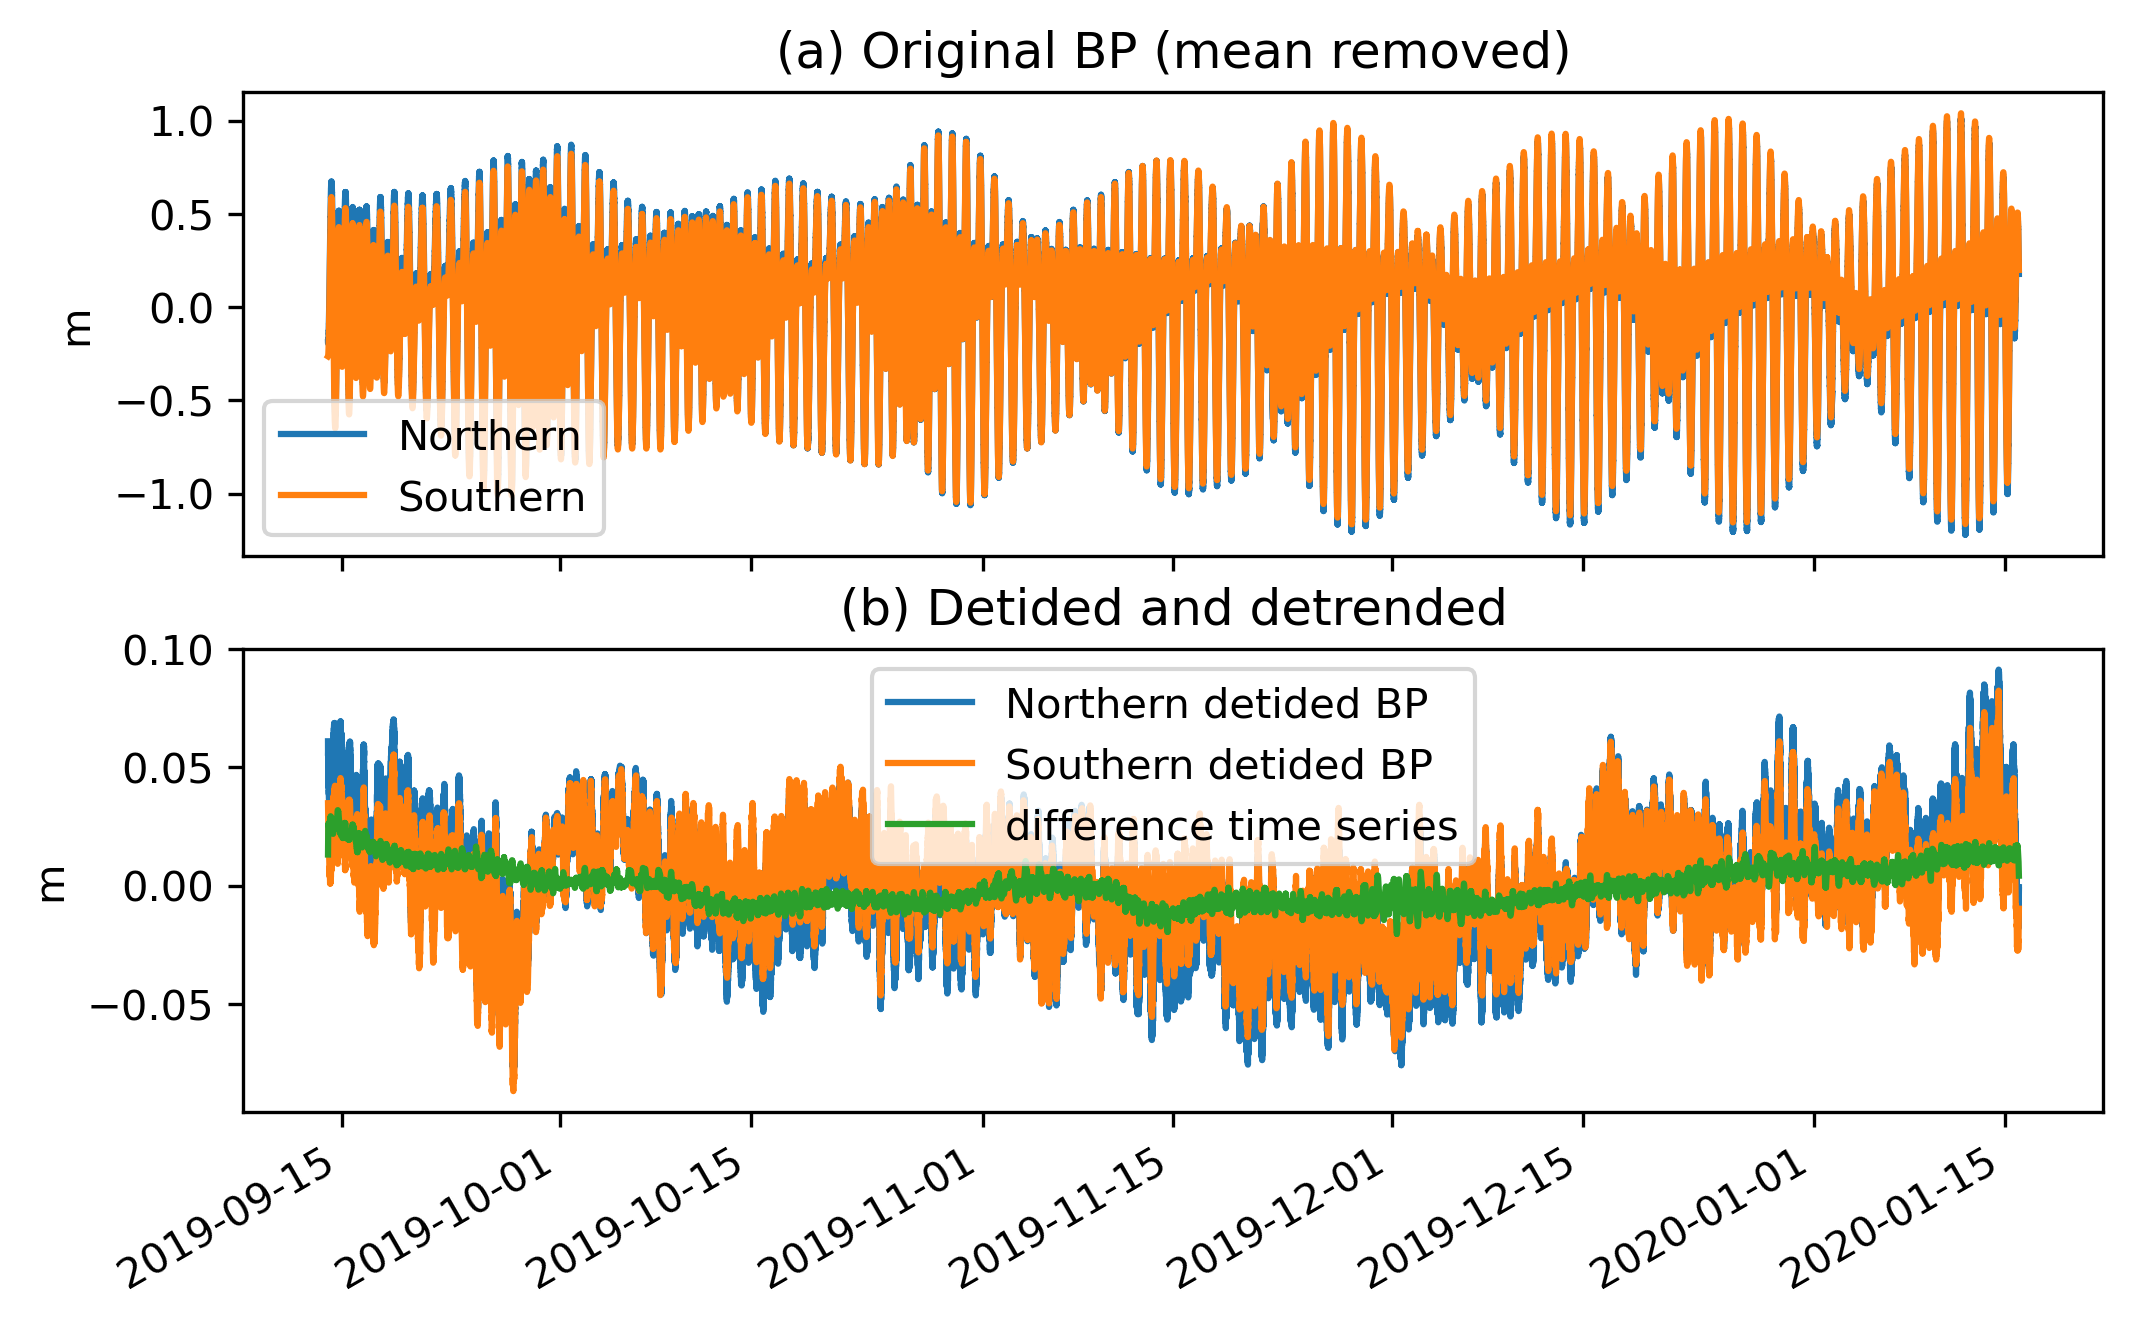

In [39]:
fig, ax = plt.subplots(2, 1)
raw = 0
detided = 1
filtered = 2
ax[raw].plot(time_pmel,bp_pmel-np.mean(bp_pmel))
ax[raw].plot(time_sio,bp_sio-np.mean(bp_sio))
ax[raw].set(ylabel='m')
ax[raw].legend(['Northern','Southern'])
ax[raw].set_title('(a) Original BP (mean removed)')

ax[detided].plot(time_pmel,bp_detided_pmel)
ax[detided].plot(time_sio,bp_detided_sio)
ax[detided].plot(time_common,bp_diff)
ax[detided].set(ylabel='m')
ax[detided].legend(['Northern detided BP','Southern detided BP','difference time series'])
ax[detided].set_title('(b) Detided and detrended')


fig.autofmt_xdate()
plt.savefig(__figdir__+'revised_Fig_17',**savefig_args)

**Figure 17. (a) The original time series of the bottom pressure from the southern (orange) and the northern (blue) BPRs. (b) The residual after removing the fitted tides and linear trends (blue and orange curves) and the difference between the two detided records (green). We fit 53 tidal constituents to the four-month-long time series to reduce the residual. The remaining signal of each BPR still has 2.3–2.6 cm standard deviation.**